## Milestone 4 

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#import required modules
from datatransform_utils import DataTransform
from plot import Plotter
import db_utils
#import matplotlib.pyplot as plt
# import numpy as np
import pandas as pd


In [2]:
### Import cleaned data from csv
df = db_utils.csv_to_dataframe('cleaned_loan_data.csv')

In [3]:
# df.info()
# df.head()

We will need to transform any data types that are not correct for our purposes.

In [4]:
transform = DataTransform()

datetime_column_list = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'last_credit_pull_date']

for date in datetime_column_list:
    # transform to period('M')
    df[date] = transform.to_datetime(df, date, '%Y-%m-%d').dt.to_period('M')
    


#### Task 1: Current state of loans

In [5]:
total_payment_to_date = df['total_payment'].sum()
total_funded_amount = df['funded_amount'].sum()
total_investor_funding = df['funded_amount_inv'].sum()

percentage_recovered_amount_funded = (total_payment_to_date / total_funded_amount) * 100
percentage_recovered_amount_funded_inv = (total_payment_to_date / total_investor_funding) * 100

print(f'Total payment to date: £{total_payment_to_date:,.2f}\n\
Total funded amount: £{total_funded_amount:,.2f}\n\
Percentage recovered against total amount funded: {percentage_recovered_amount_funded:.2f}%\n\
Percentage recovered agaisnt investor funded: {percentage_recovered_amount_funded_inv:.2f}%')

Total payment to date: £654,573,341.64
Total funded amount: £716,618,800.00
Percentage recovered against total amount funded: 91.34%
Percentage recovered agaisnt investor funded: 93.29%


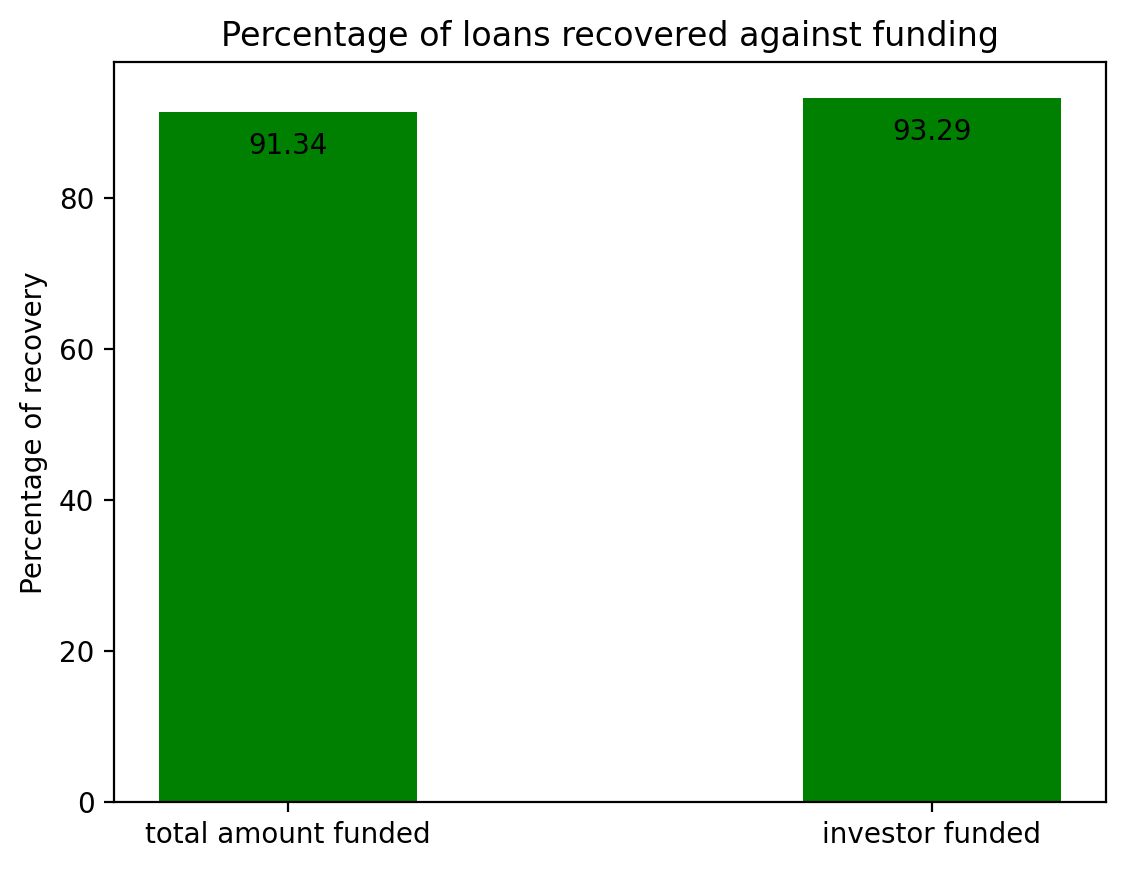

In [6]:
#Plot bar chart
plot = Plotter()

xs = ['total amount funded', 'investor funded']
ys = [percentage_recovered_amount_funded, percentage_recovered_amount_funded_inv]

plot.plot_bar_chart(xs, ys, width=0.4, title='Percentage of loans recovered against funding', ylabel='Percentage of recovery',
                    annotate=True, xy_text=(0, -15))

In [7]:
# pd.set_option('display.max_columns', None)
# df[df['loan_status']=='Default'].head(50)
#pd.reset_option('max_columns')

### Recovery prediction for next 6 months

In [8]:
#Get the latest payment date from the data and start prediction from this date
prediction_start_date = df['last_payment_date'].max()

#Check unique values in loan status
print(df['loan_status'].unique())

['Current' 'Fully Paid' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)' 'Default'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


For the prediction we will only take loans which are marked as *current* and *In Grace Period* to be conservative.

In [9]:
active_loans = df[(df['loan_status'] == 'Current') | (df['loan_status'] == 'In Grace Period')].copy()

### Check number of installments left on each account
active_loans['end_date'] = active_loans['issue_date'] + active_loans['term']
active_loans['months_left'] = active_loans['end_date'] - prediction_start_date
#Convert months_left to int
active_loans['months_left'] = active_loans['months_left'].apply(lambda p: p.n)

Upon inspection there appear to be some loans with negative and zero terms left even though they were mark as current. I will remove these rows.

In [10]:
active_loans = active_loans[active_loans['months_left']>0]

We will now calculate the amounts recovered for each month over the next 6 months and calculate the total pecentage of the loan recovered for these months.

In [11]:
#Calculate predicted collected revenue per month over the next six months
sum_recovered_month = []

for period in range(1,7):
    #Get active loans for period
    loans_active = active_loans[active_loans['months_left']>=period]
    #Sum installments
    recovered = loans_active['instalment'].sum()
    #Add to list
    sum_recovered_month.append(recovered)


#Calculate total loan amount
total_loan = df['loan_amount'].sum()

In [12]:
#Claculate percentage of total loan recovered each month
percentage_recovered_start = (total_payment_to_date / total_loan) * 100
percentage_list = [percentage_recovered_start]
recovered_sum = 0

print(f'Projected percentage of total loan recovery over a six month period: \n')
for i in range(0,6):
    recovered_sum = sum_recovered_month[i] + recovered_sum
    recovered_percentage_month = ((total_payment_to_date + recovered_sum )/ total_loan) * 100
    percentage_list.append(recovered_percentage_month)
    print(f'Month {i+1}: {recovered_percentage_month:.2f}%')


Projected percentage of total loan recovery over a six month period: 

Month 1: 91.86%
Month 2: 93.05%
Month 3: 94.23%
Month 4: 95.41%
Month 5: 96.59%
Month 6: 97.77%


Below is a plot of the projection.

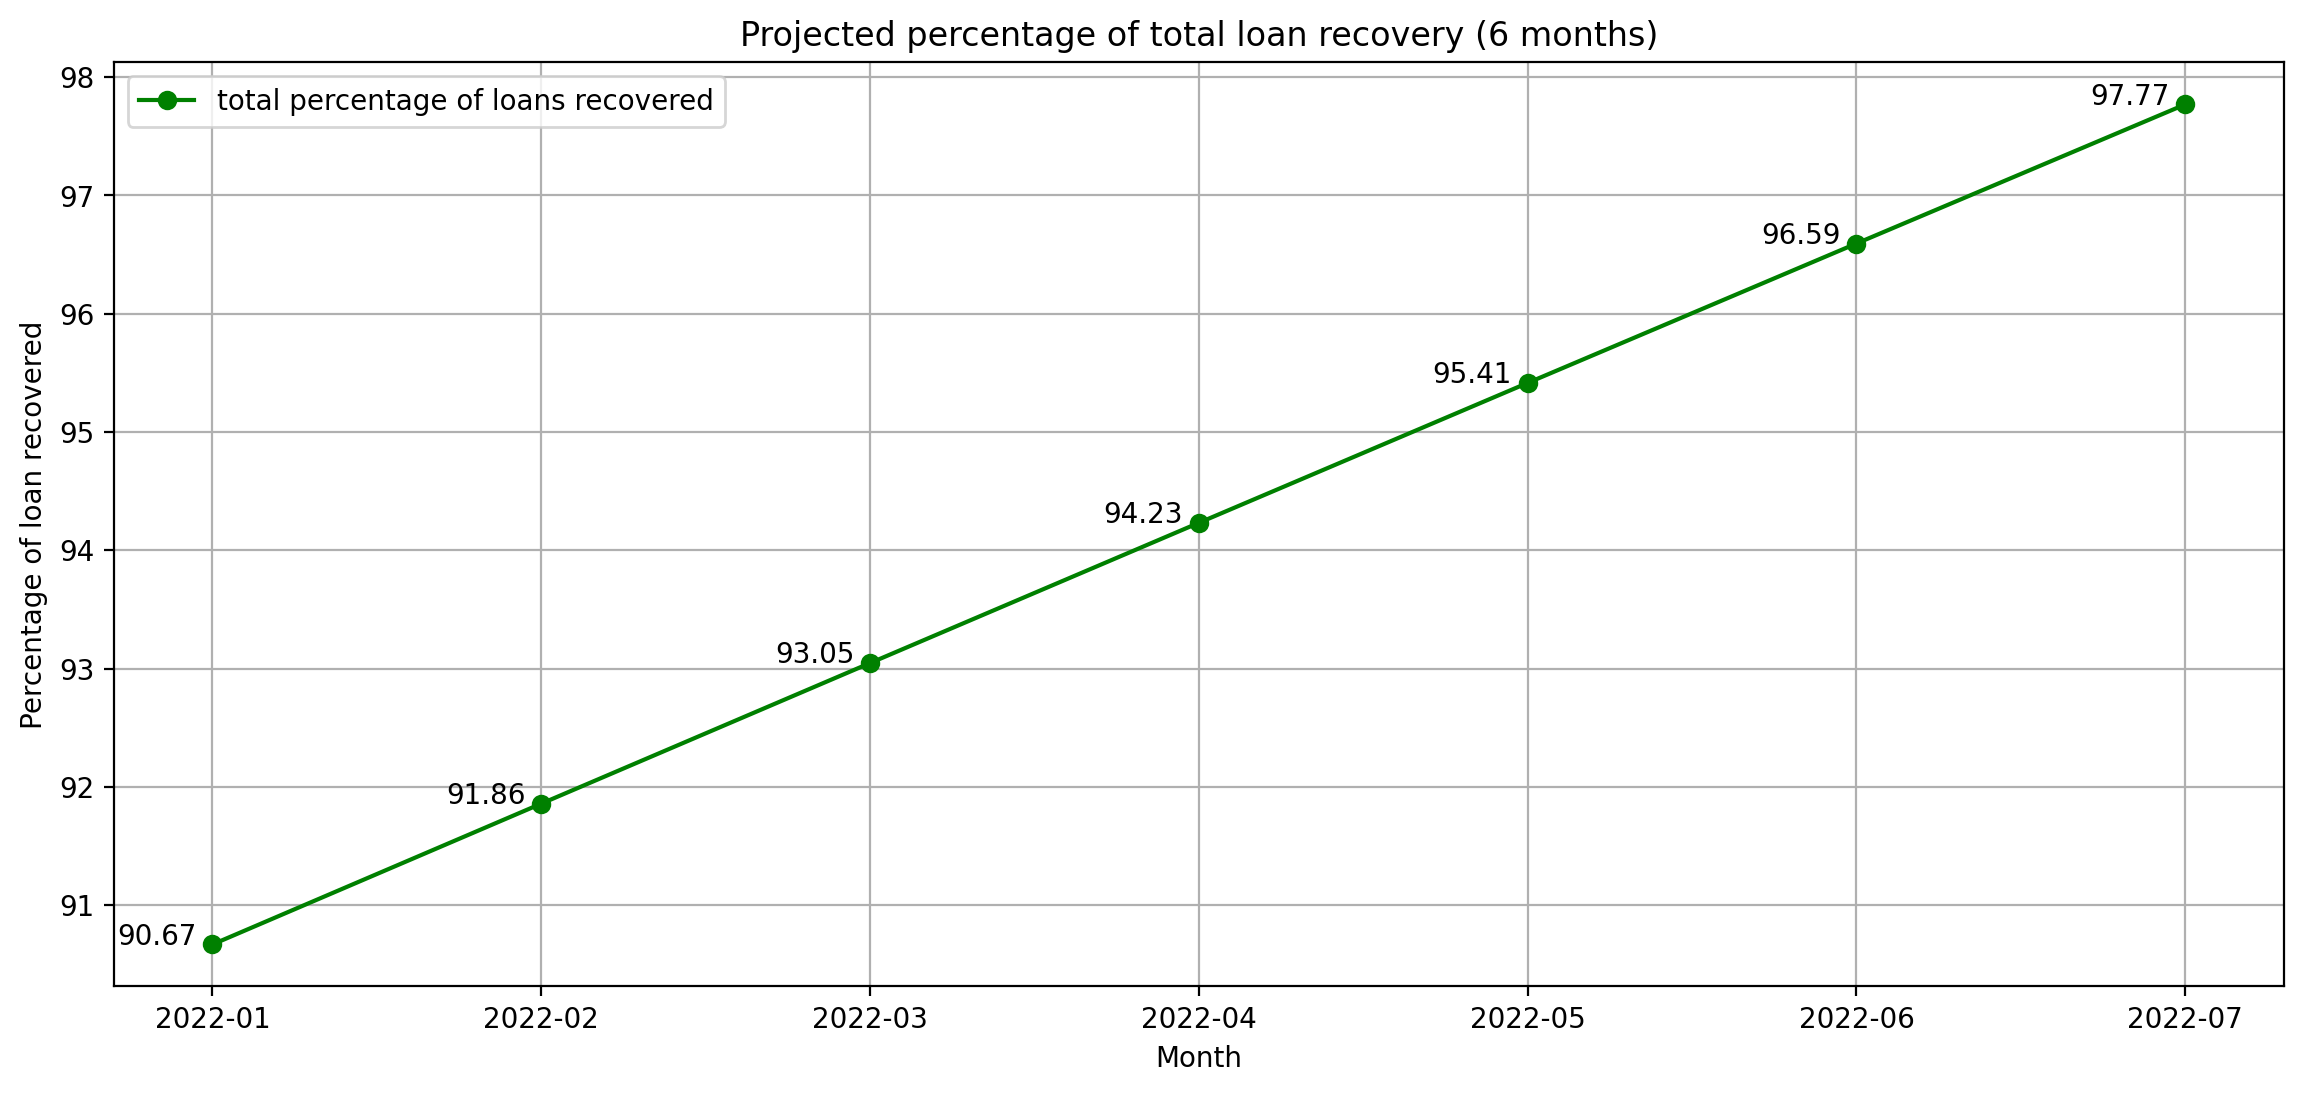

In [13]:
# Plot results
dates = ['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07']

plot.plot_line2d(dates, percentage_list, label='total percentage of loans recovered', marker='o', fig_size=(14, 6),
                 xlabel='Month', ylabel='Percentage of loan recovered', title='Projected percentage of total loan recovery (6 months)',
                 legend=True, grid=True, annotate=True, xy_text=(-20, 0)
                 )

### Task 2: Calculating loss

In [14]:
#Filter charged_off loans
charged_off = df[df['loan_status'].isin(['Does not meet the credit policy. Status:Charged Off', 'Charged Off' ])].copy()

percentage_charged_off = (charged_off.shape[0] / df.shape[0]) * 100
charged_off_amount_paid = charged_off['total_payment'].sum()
total_charged_off_loans = charged_off['loan_amount'].sum()
percentage_charged_off_paid = (charged_off_amount_paid / total_charged_off_loans) * 100

print(
f'The percentage of charged off loans historically is {percentage_charged_off:.2f}%.\
 The total amount borrowed for these loans is £{total_charged_off_loans:,} of which\
\n£{charged_off_amount_paid:,.2f} was recovered. This amounts to {percentage_charged_off_paid:.2f}%\
 of the total amount borrowed on these accounts being recovered.') 


The percentage of charged off loans historically is 10.82%. The total amount borrowed for these loans is £79,191,325 of which
£39,092,575.24 was recovered. This amounts to 49.36% of the total amount borrowed on these accounts being recovered.


In [15]:
#charged_off.columns.values.tolist()

### Task 3: Calculating projected loss

The expected loss of revenue from charged of loans is £66,470,516.60.
This is approximaley 7.18% of the expected total revenue.


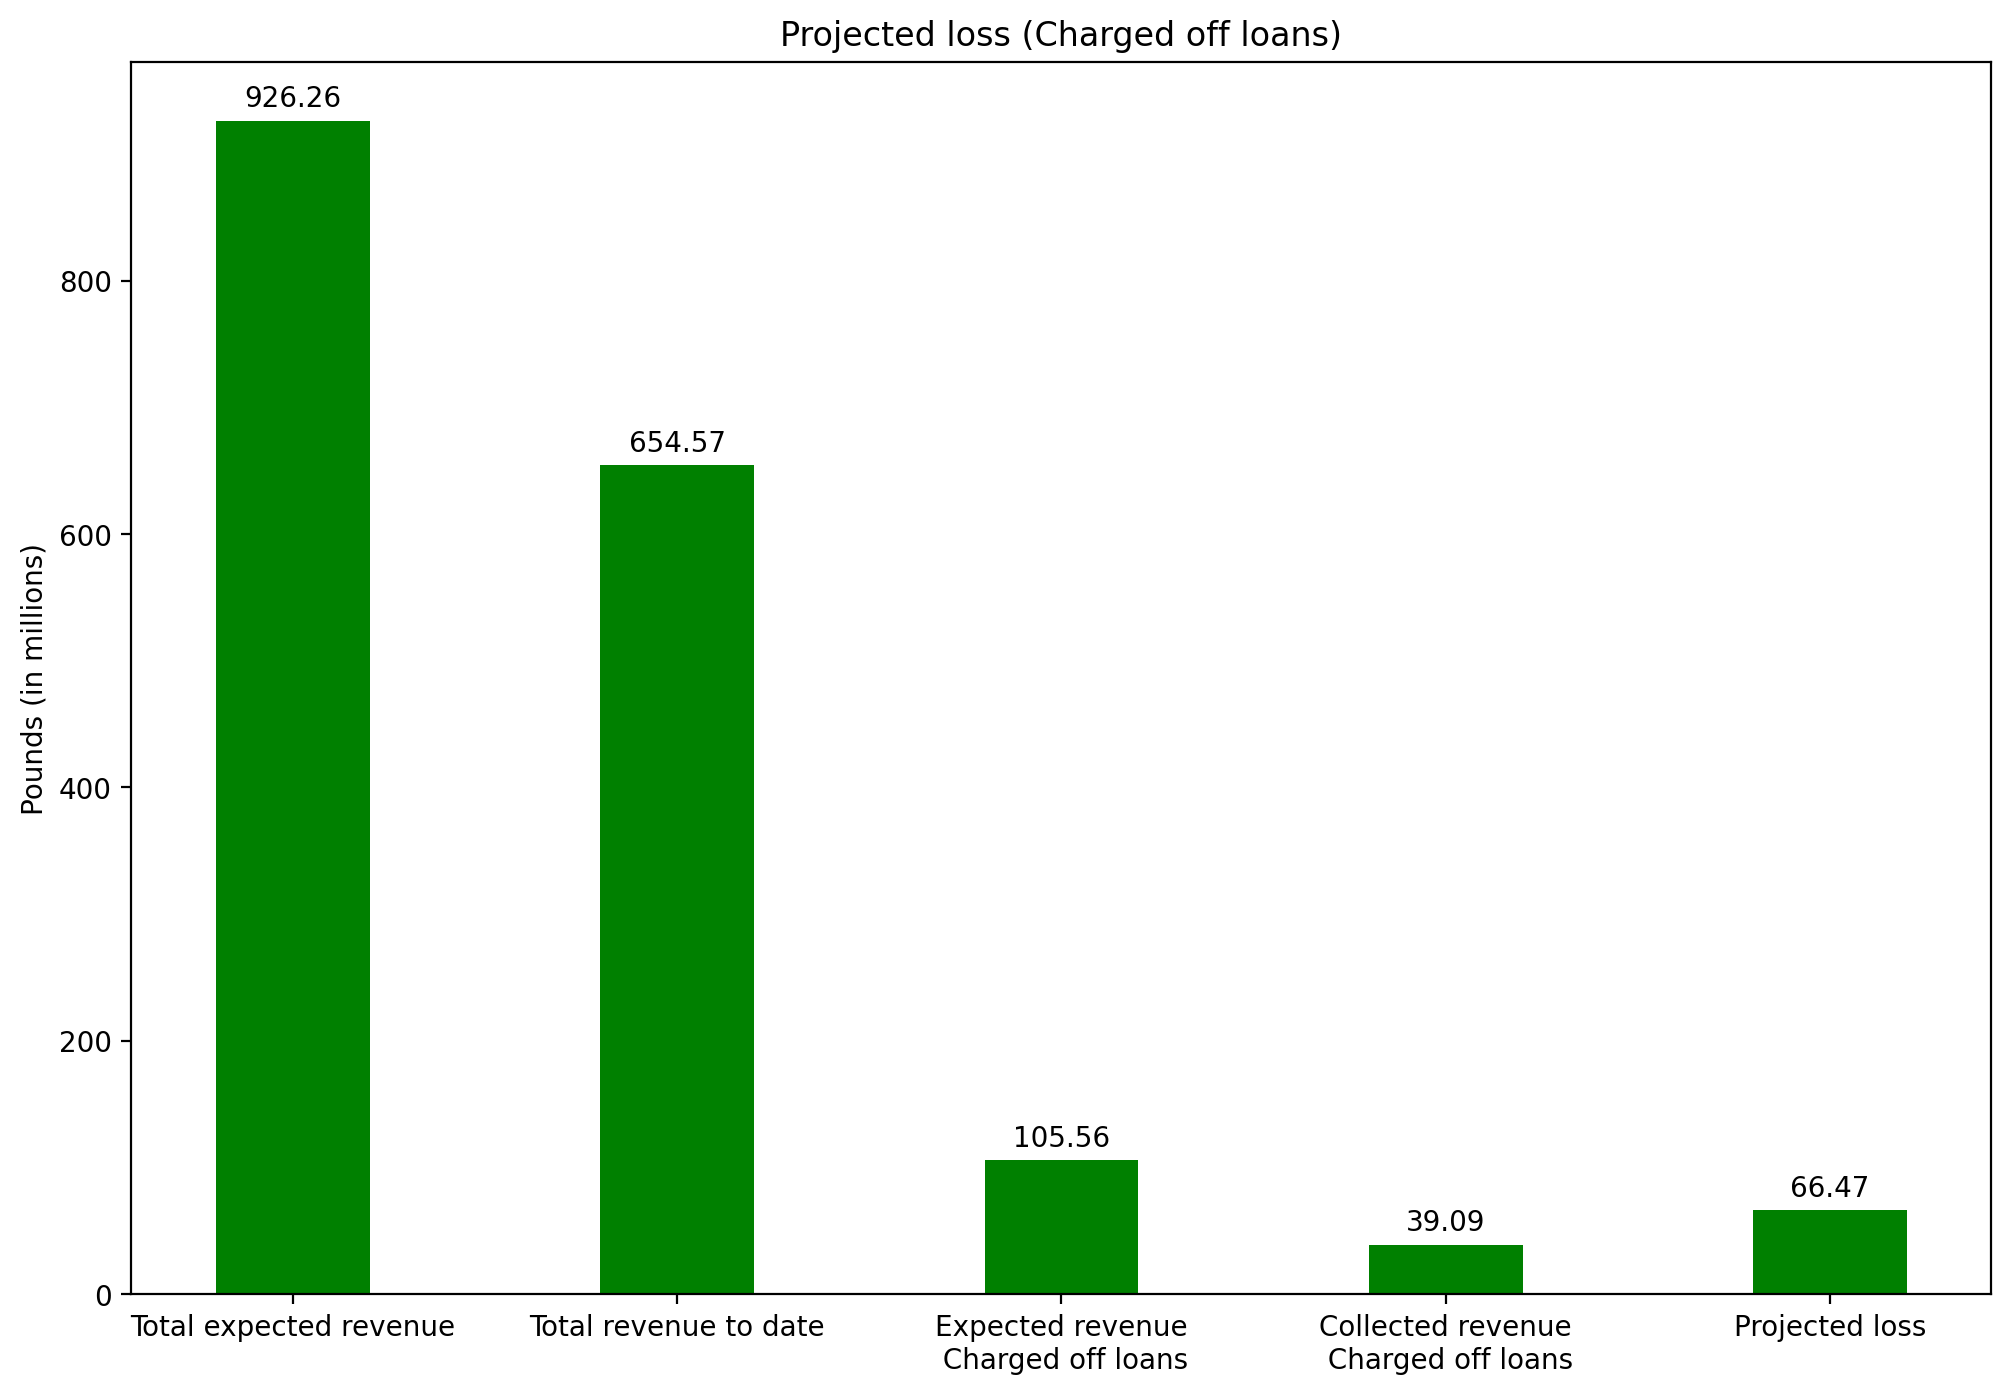

In [16]:
charged_off['expected_total_amount'] = charged_off['term'] * charged_off['instalment']
charged_off['expected_loss'] = charged_off['expected_total_amount'] - charged_off['total_payment']

total_charged_off_loss = charged_off['expected_loss'].sum()
#expected_loss = total_expected_payment - total_charged_off_payment

total_expected_revenue = (df['term'] * df['instalment']).sum()
total_percentage_loss = (total_charged_off_loss / total_expected_revenue) * 100

total_charged_off_expected_revenue = charged_off['expected_total_amount'].sum()
total_charged_off_revenue = charged_off['total_payment'].sum()


print(f'The expected loss of revenue from charged of loans is £{total_charged_off_loss:,.2f}.\
\nThis is approximaley {total_percentage_loss:.2f}% of the expected total revenue.')

#Plot bar chart
xs = ['Total expected revenue', 'Total revenue to date', 'Expected revenue\n Charged off loans',
      'Collected revenue\n Charged off loans','Projected loss']
scale = 1000000
ys = [total_expected_revenue / scale, total_payment_to_date / scale, total_charged_off_expected_revenue / scale,
      total_charged_off_revenue / scale  ,total_charged_off_loss / scale ]

plot.plot_bar_chart(xs, ys, width=0.4, title='Projected loss (Charged off loans)',
                    ylabel='Pounds (in millions)', fig_size=(12, 8), annotate=True, xy_text=(0,5))

# instalment calculation if needed
# def mnthly_instalments(loan_amount, term, interest):
#     r = (interest * 0.01) / 12
#     n = term
#     p = ( ((1 + r)**n)-1) / (r*(1 + r)**n)
#     return(loan_amount / p)
#


### Task 4: Possible loss

In [17]:
#Create new dataframe of customers with late payments
customers_late_payment = df[df['loan_status'].isin(['Late (31-120 days)', 'Late (16-30 days)'])].copy()

late_payments_count = len(customers_late_payment)
percentage_late_payments = (late_payments_count / len(df)) * 100

customers_late_payment['expected_revenue'] = customers_late_payment['term'] * customers_late_payment['instalment']
customers_late_payment['projected_loss'] = customers_late_payment['expected_revenue'] - customers_late_payment['total_payment']

projected_loss_late_payments = customers_late_payment['projected_loss'].sum()

#Create dataframe of customers who have defaulted
customers_defaulted = df[df['loan_status'] == 'Default'].copy()
customers_defaulted['expected_revenue'] = customers_defaulted['term'] * customers_defaulted['instalment']
customers_defaulted['loss'] = customers_defaulted['expected_revenue'] - customers_defaulted['total_payment']

customer_defaulted_loss = customers_defaulted['loss'].sum()

total_loss_late_charged = total_charged_off_loss + projected_loss_late_payments + customer_defaulted_loss

perecentage_total_loss_late_charged = (total_loss_late_charged / total_expected_revenue) * 100

print(f'There are {late_payments_count} customers who are behind with their payments.\
 This represents approximately {percentage_late_payments:.2f}% of all customers.\n\
The expected loss of revenue from these loans is £{projected_loss_late_payments:,.2f}. \
Adding this sum to the expected loss of customers who have\nalready defaulted \
gives a expected loss of £{total_loss_late_charged:,.2f}, which is approximately \
{perecentage_total_loss_late_charged:.2f}% of the total \
expected\nrevenue.')

There are 686 customers who are behind with their payments. This represents approximately 1.27% of all customers.
The expected loss of revenue from these loans is £7,316,814.49. Adding this sum to the expected loss of customers who have
already defaulted gives a expected loss of £74,331,517.57, which is approximately 8.02% of the total expected
revenue.


### Task 5: Indicators of loss

In [18]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# create dataframe of defaluted loans
defaulted_subset = df[df['loan_status'].isin(['Does not meet the credit policy. Status:Charged Off', 'Charged Off', 'Default'])].copy()

# grade = defaulted_subset['grade'].value_counts(normalize=True) * 100
# purpose = defaulted_subset['purpose'].value_counts(normalize=True) * 100
# home_owner = defaulted_subset['home_ownership'].value_counts(normalize=True) * 100

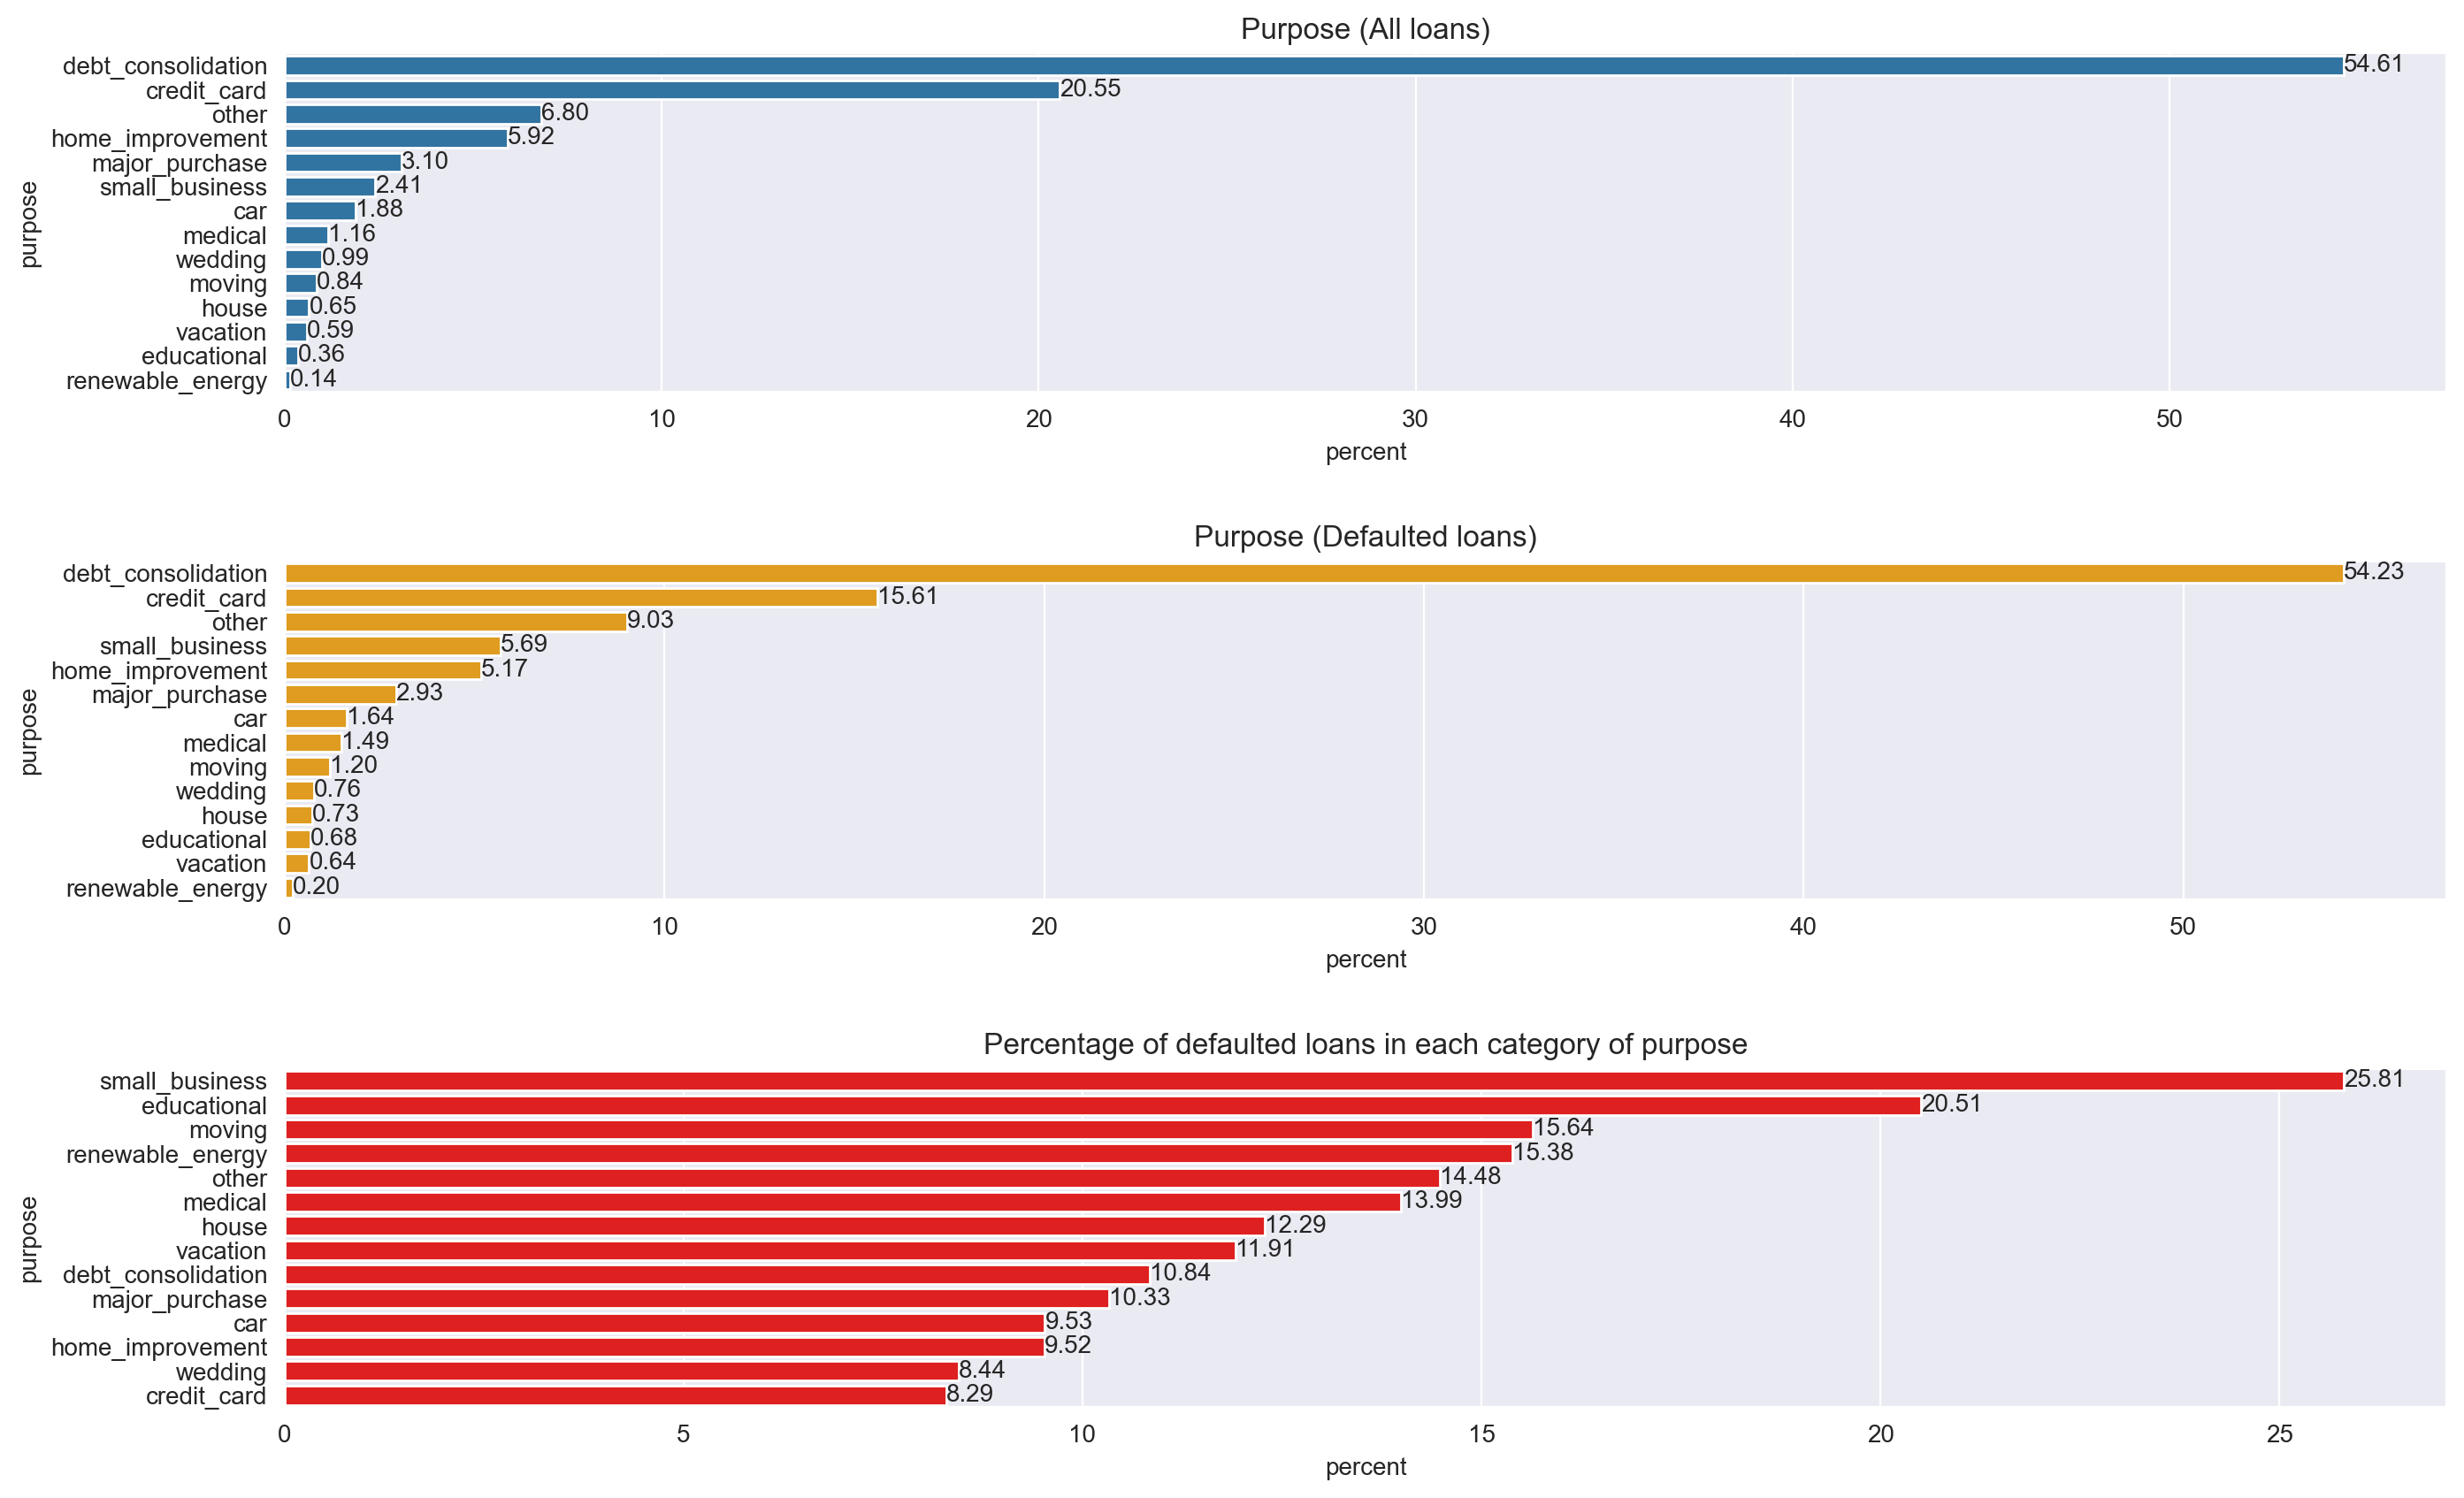

In [19]:
plot.plot_risk_comparison(df, defaulted_subset, 'purpose', 'purpose', title_1='Purpose (All loans)', title_2='Purpose (Defaulted loans)',
                          ylabel_1='purpose', ylabel_2='purpose', fig_size=(14,10), padding=5)

We see that almost 55% of loans taken out are for debt consolidation. Looking at he second plot, which shows the distribution of categories in already defaulted loans, we see that debt consolidation accounted for around 55% of defaulted loans, so does not imply an increased risk compared to the other categories. Categories that have increased there representation in the second plot include *educational*, *moving*, *other*, and *renewable energy*. But most noteworthy is *small buisnesses* which has more than doubled its percentage in the second plot. Looking at the last plot, which visualises the perecentage of loans defaulting in each category, we see that almost 26% of loans taken for small buisnesseses have defaulted, the highest for the purpose category. This suggests that this group could be of higher risk of defaulting than the others. This is followed by loans taking for *educational* and *moving*.

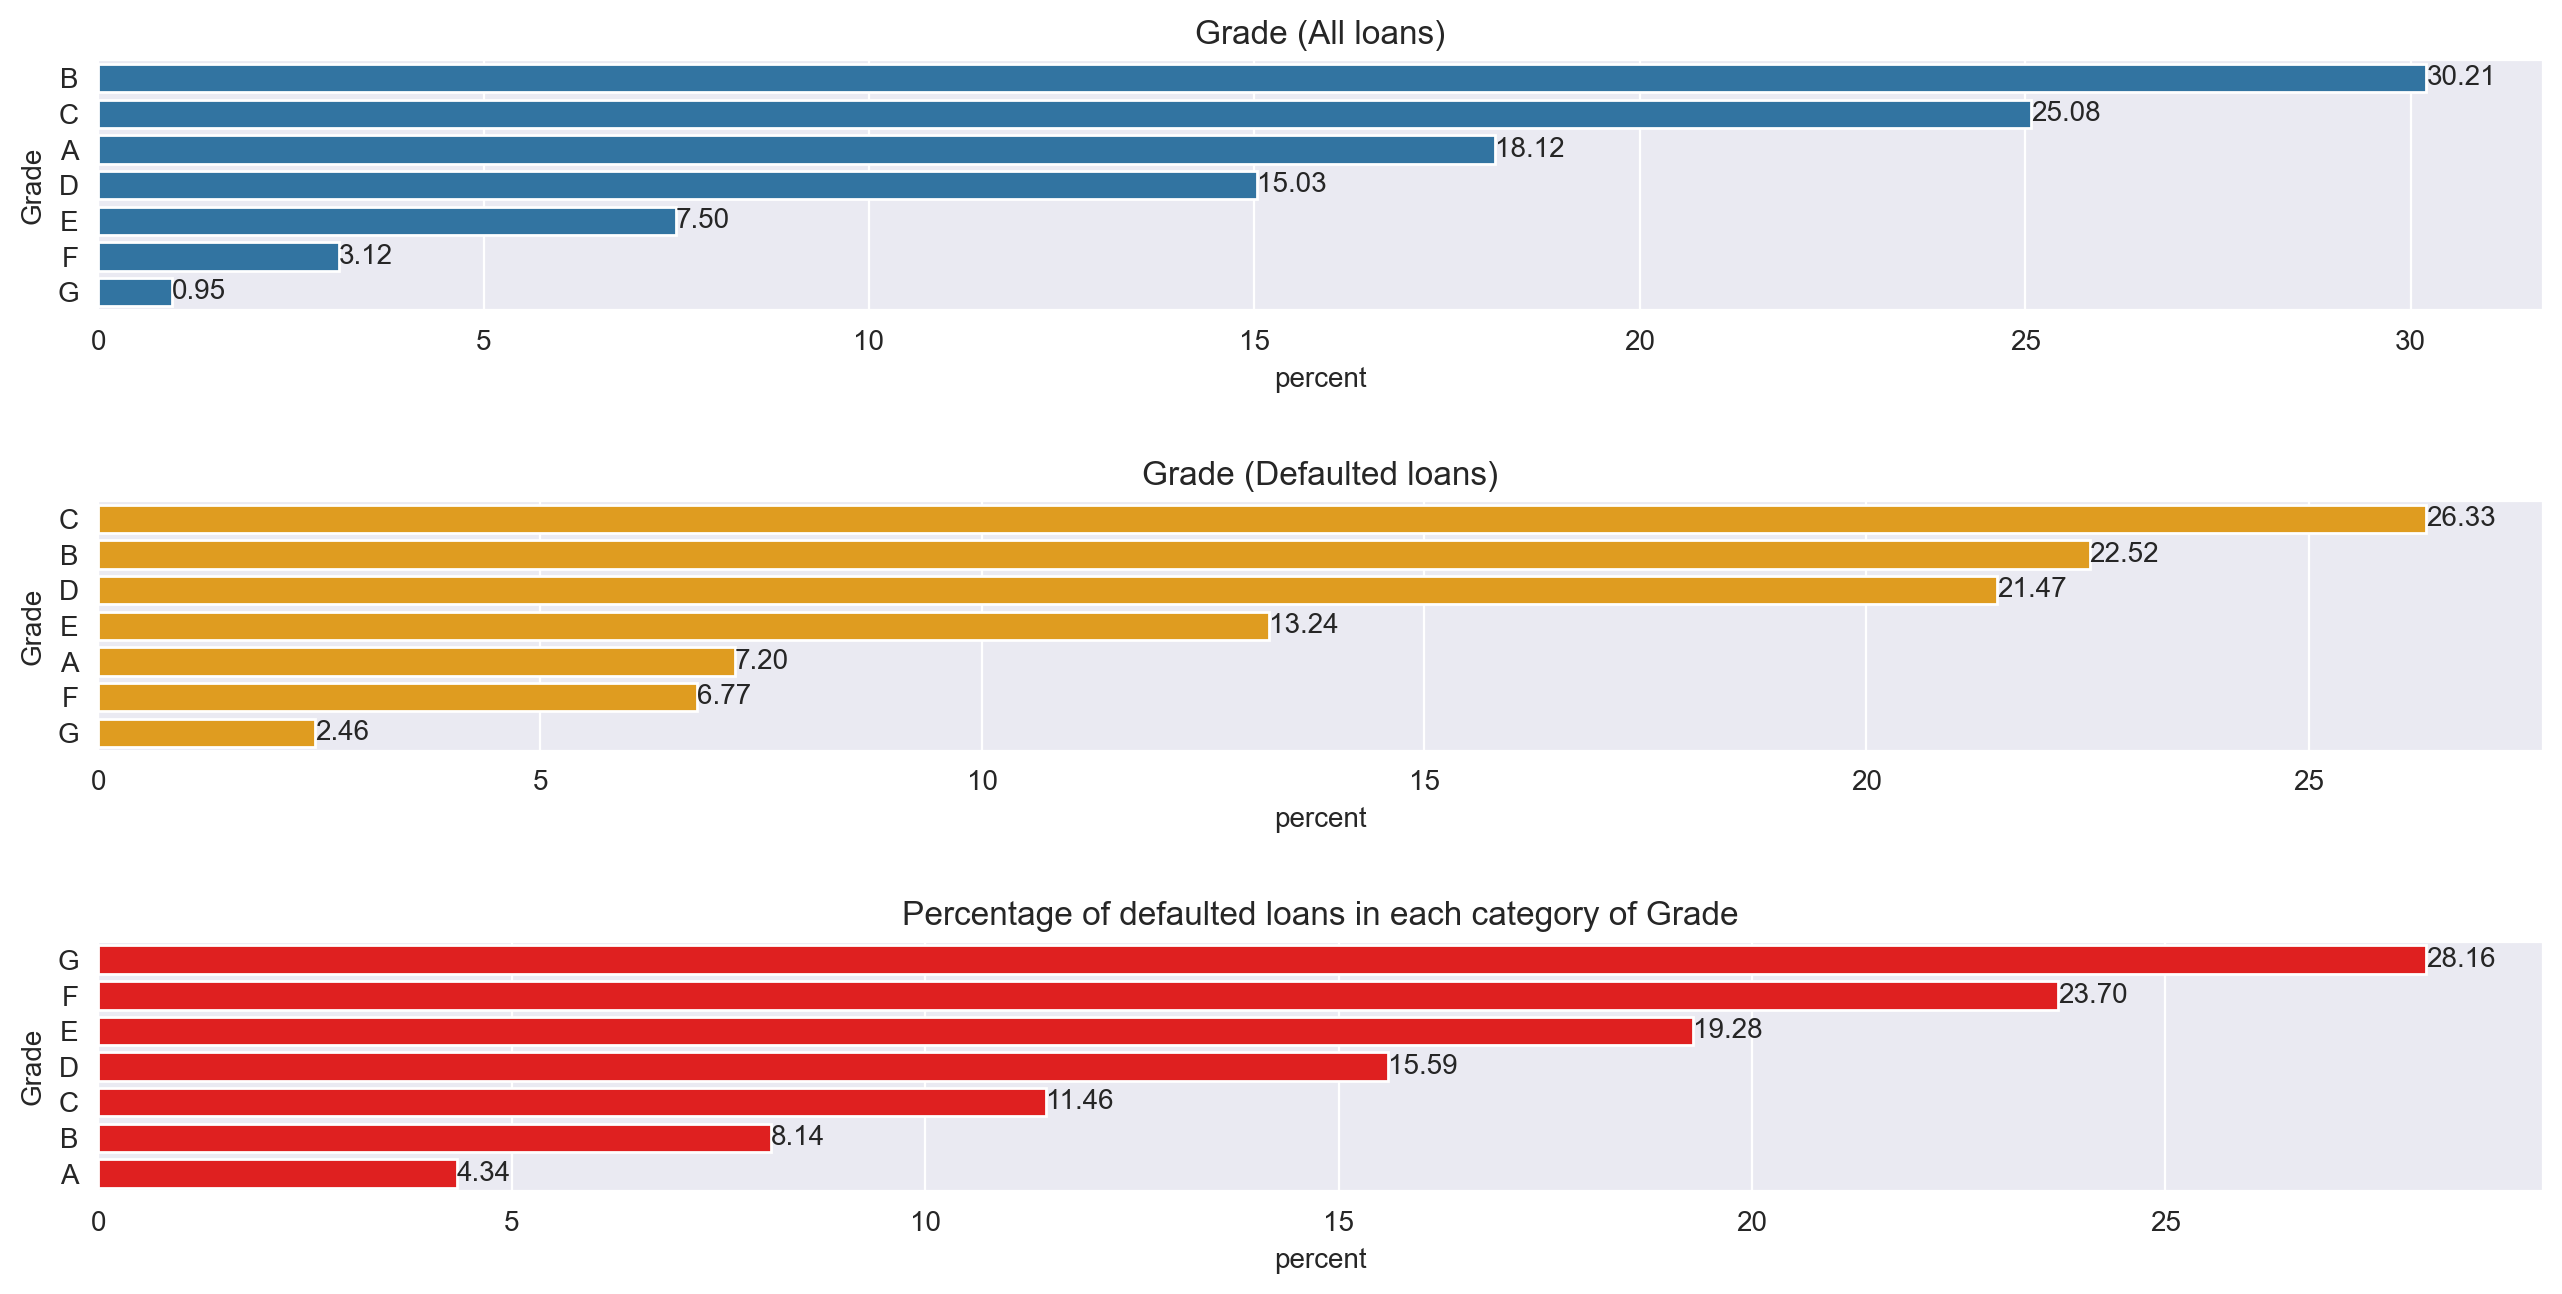

In [20]:
plot.plot_risk_comparison(df, defaulted_subset, 'grade', 'grade', title_1='Grade (All loans)', title_2='Grade (Defaulted loans)',
                          ylabel_1='Grade', ylabel_2='Grade',fig_size=(14,8), padding=5)

Now examining the grade category we see that grade B and grade C account for over 50% of the loans, with grade B most dominant. In the second plot we see that grade C has become the most dominant. The lower grades have increased their percentage while grade A has decreased its representation. Looking at the last plot we see a linear relationship between the percentage of defaulted loans and grade, the lower the grade the higher the occurrence of defaulting. This suggests that grade level is a good indicator of risk of defaulting.

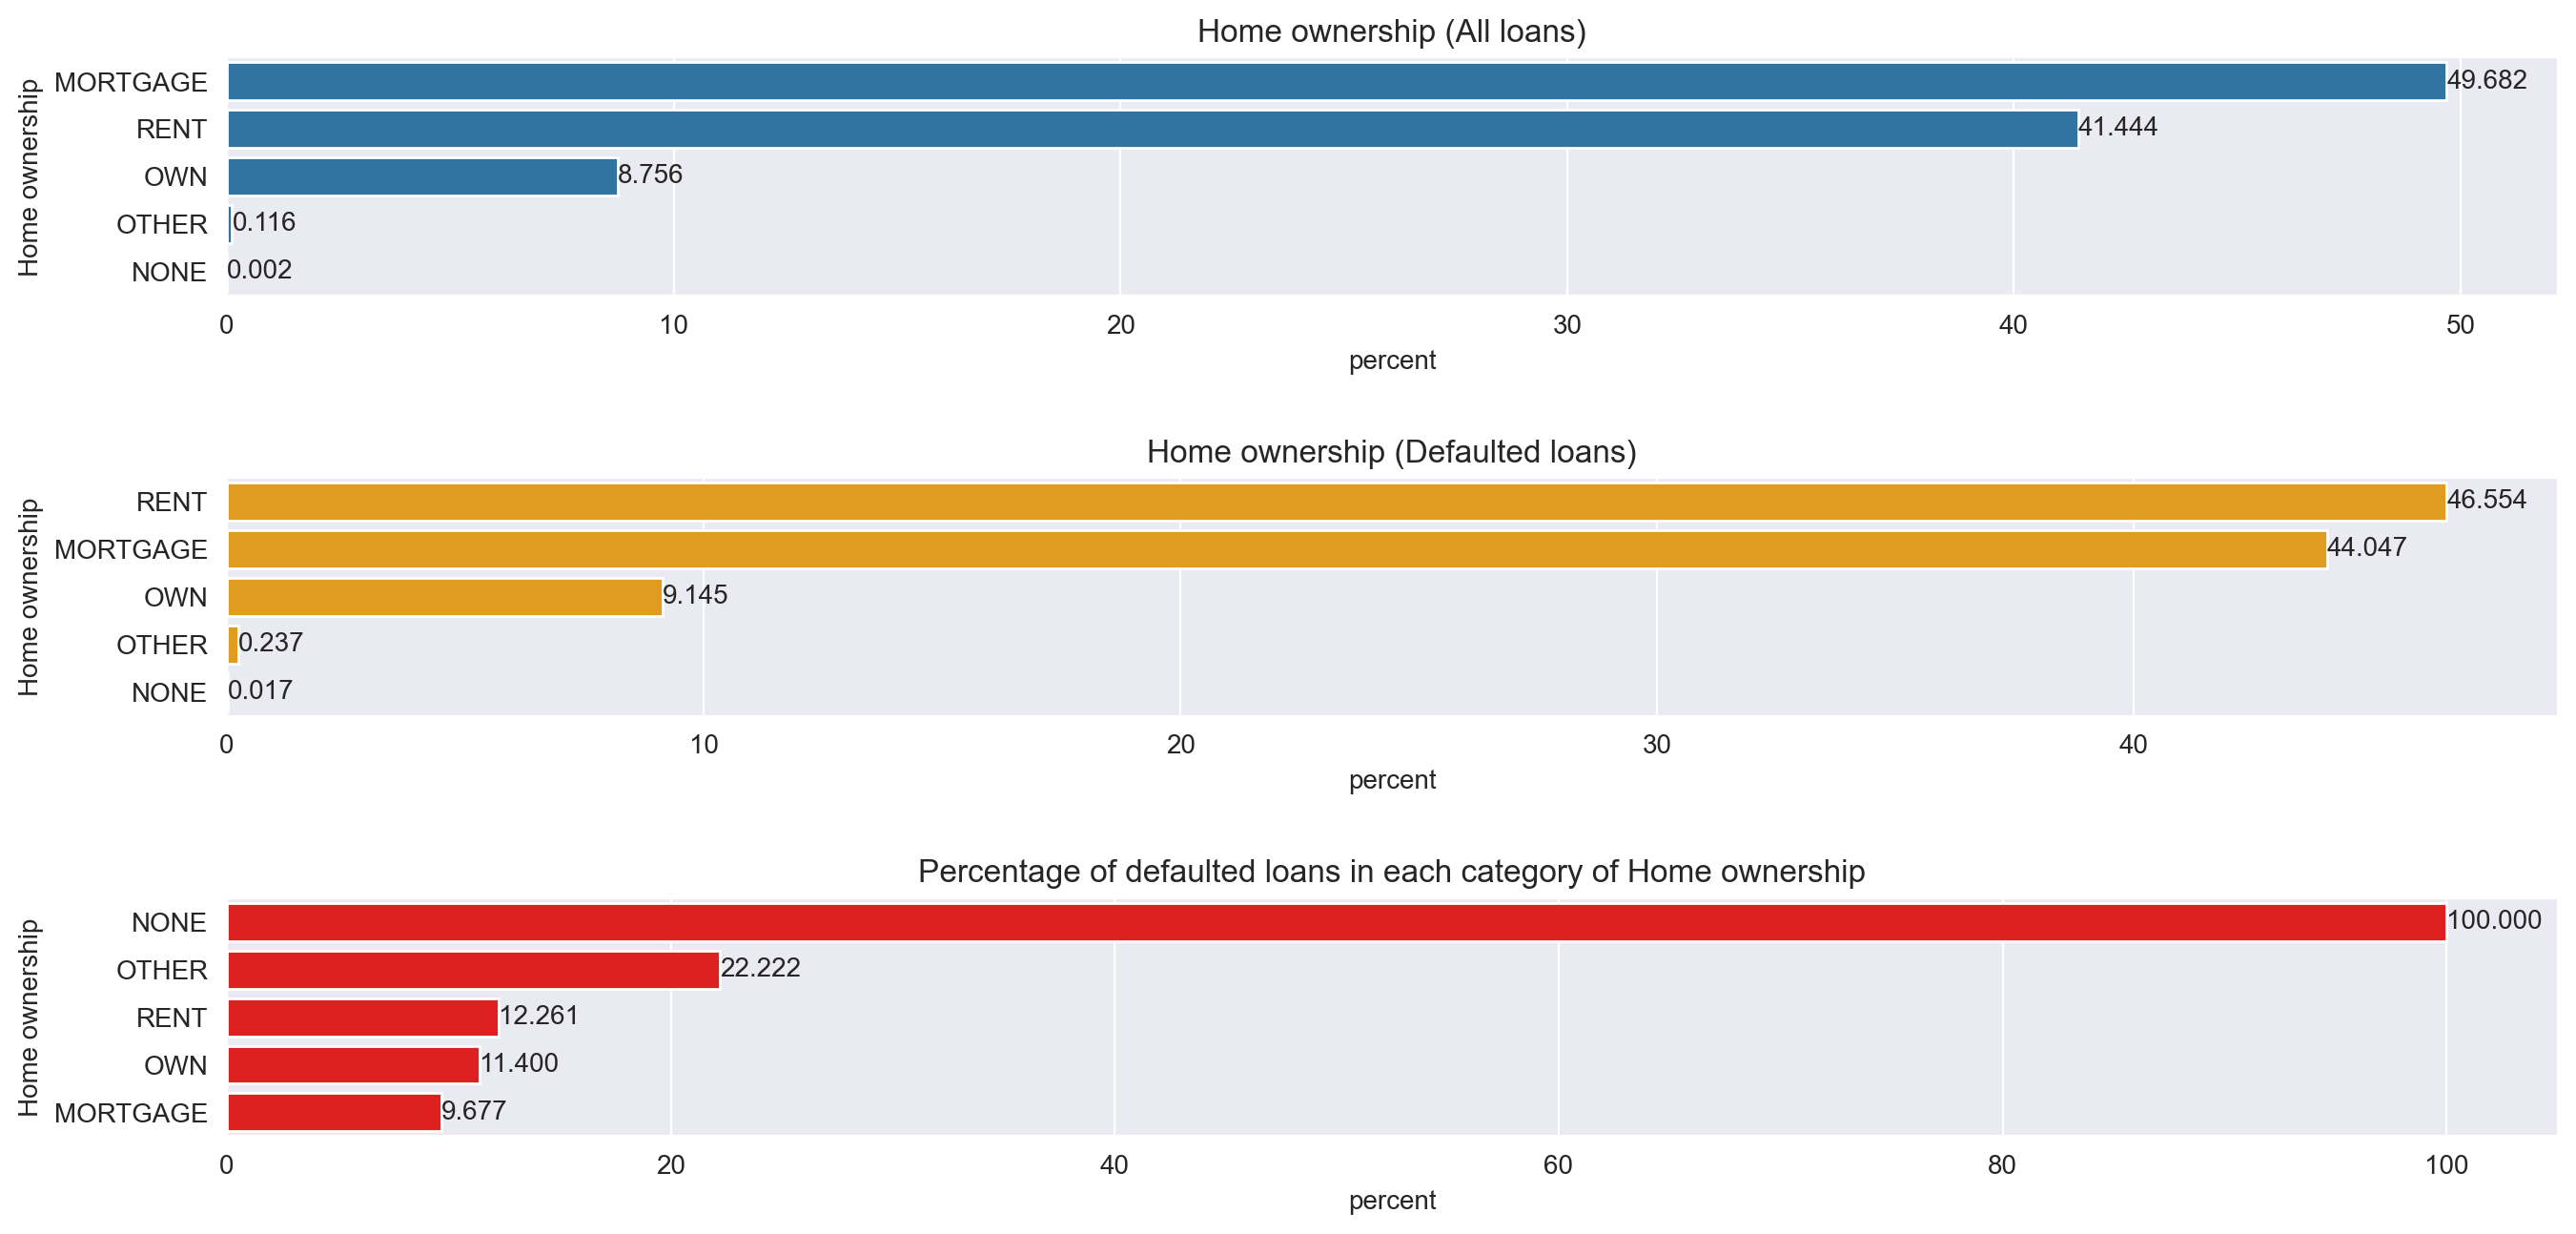

In [21]:
plot.plot_risk_comparison(df, defaulted_subset, 'home_ownership', 'home_ownership', title_1='Home ownership (All loans)',
                          title_2='Home ownership (Defaulted loans)', ylabel_1='Home ownership', ylabel_2='Home ownership', 
                          fmt='%.3f',fig_size=(14,8), padding=5)

Home ownership is dominated by the mortgage an rental groups. I am not sure what the none category represents or what the other group consists off making it difficult to assess these properly, but looking at the plots suggest the lowest risk group is *mortgage* followed by *own* with *rent* being of slightly increeased risk. There is not much between these groups suggesting that home ownership is not a good indicator of loss.

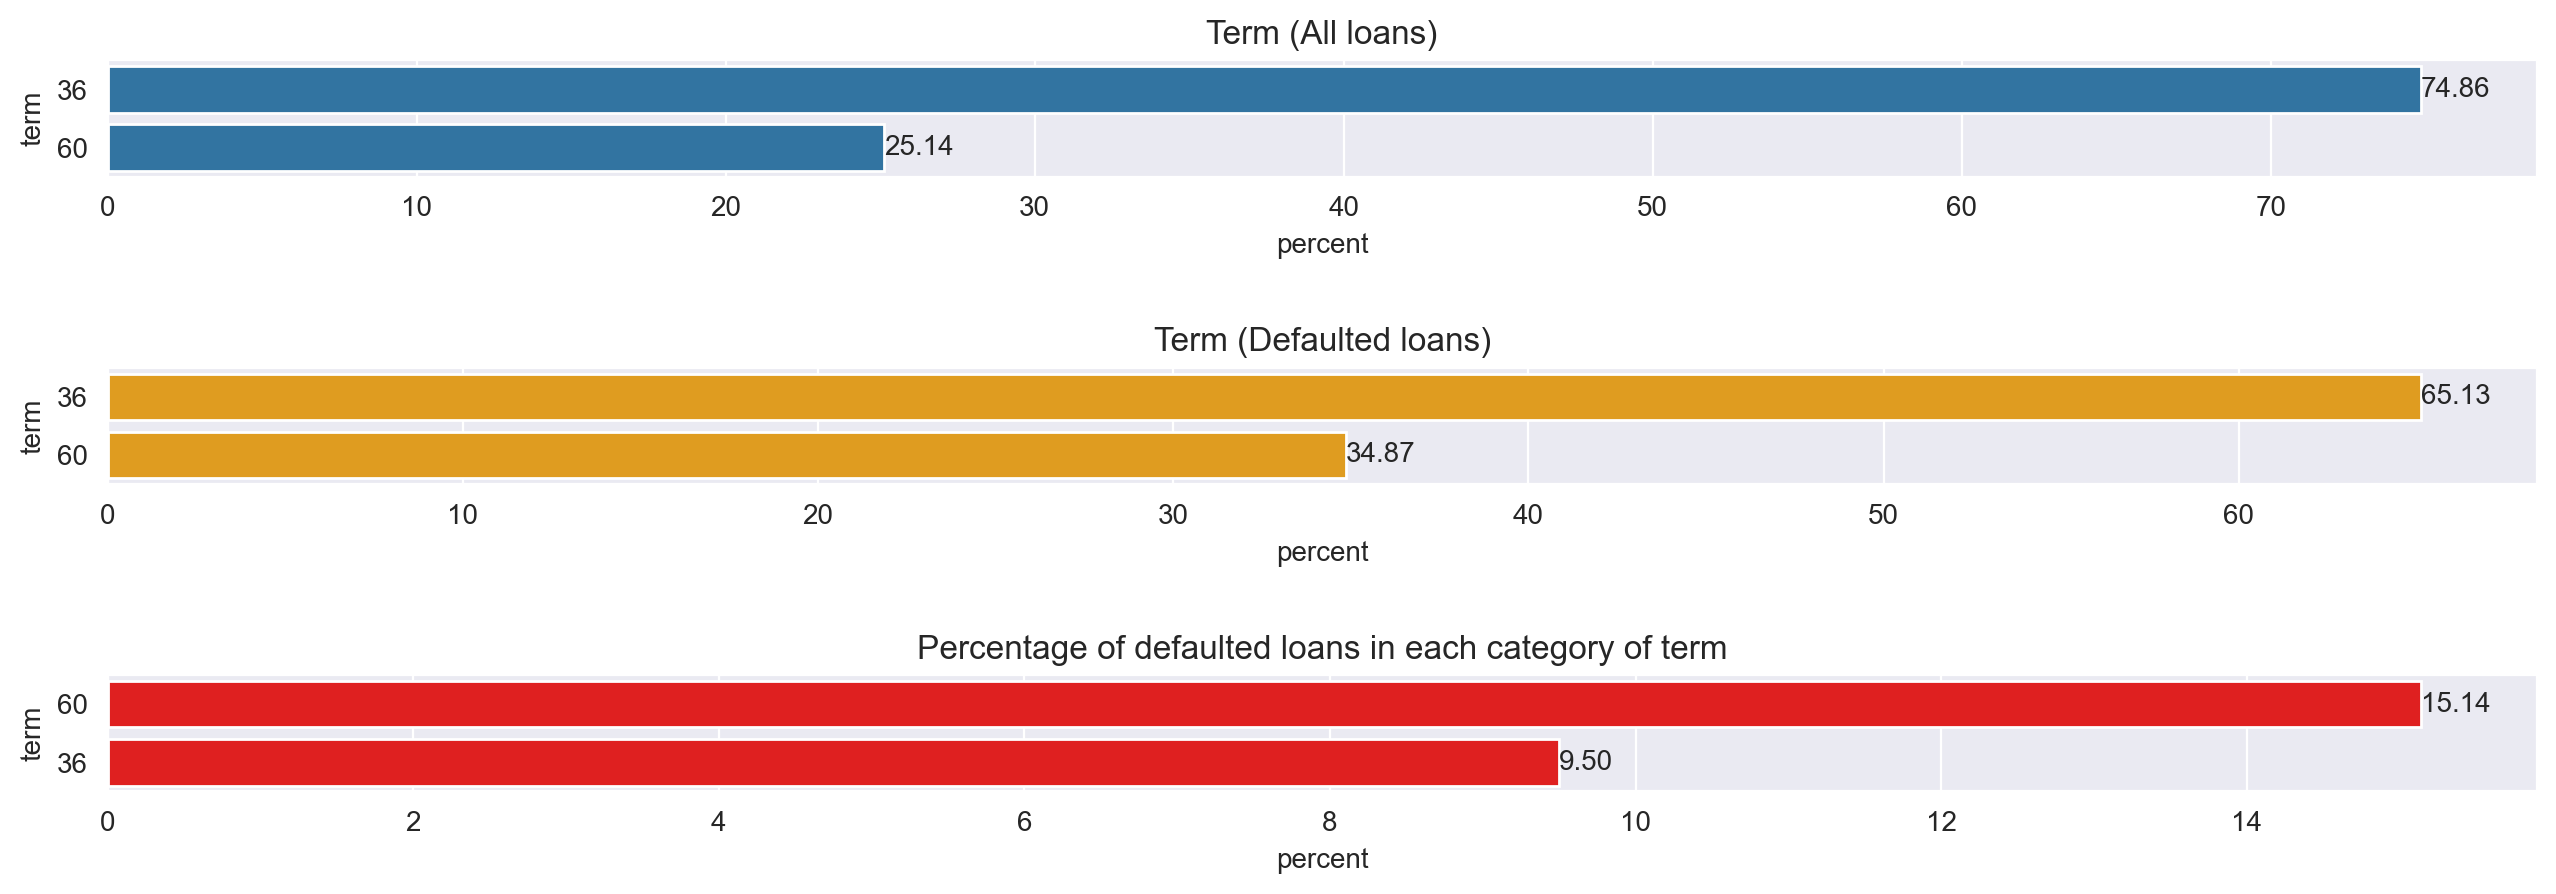

In [22]:
plot.plot_risk_comparison(df, defaulted_subset, 'term', 'term', title_1='Term (All loans)', title_2='Term (Defaulted loans)',
                          ylabel_1='term', ylabel_2='term',fig_size=(14,6), padding=5)

Turning to the *term* category, which only has two groups, the plots suggest maybe a longer term is slightly more at risk of defaulting than a shorter one with shorter terms being under represented in the second plot.

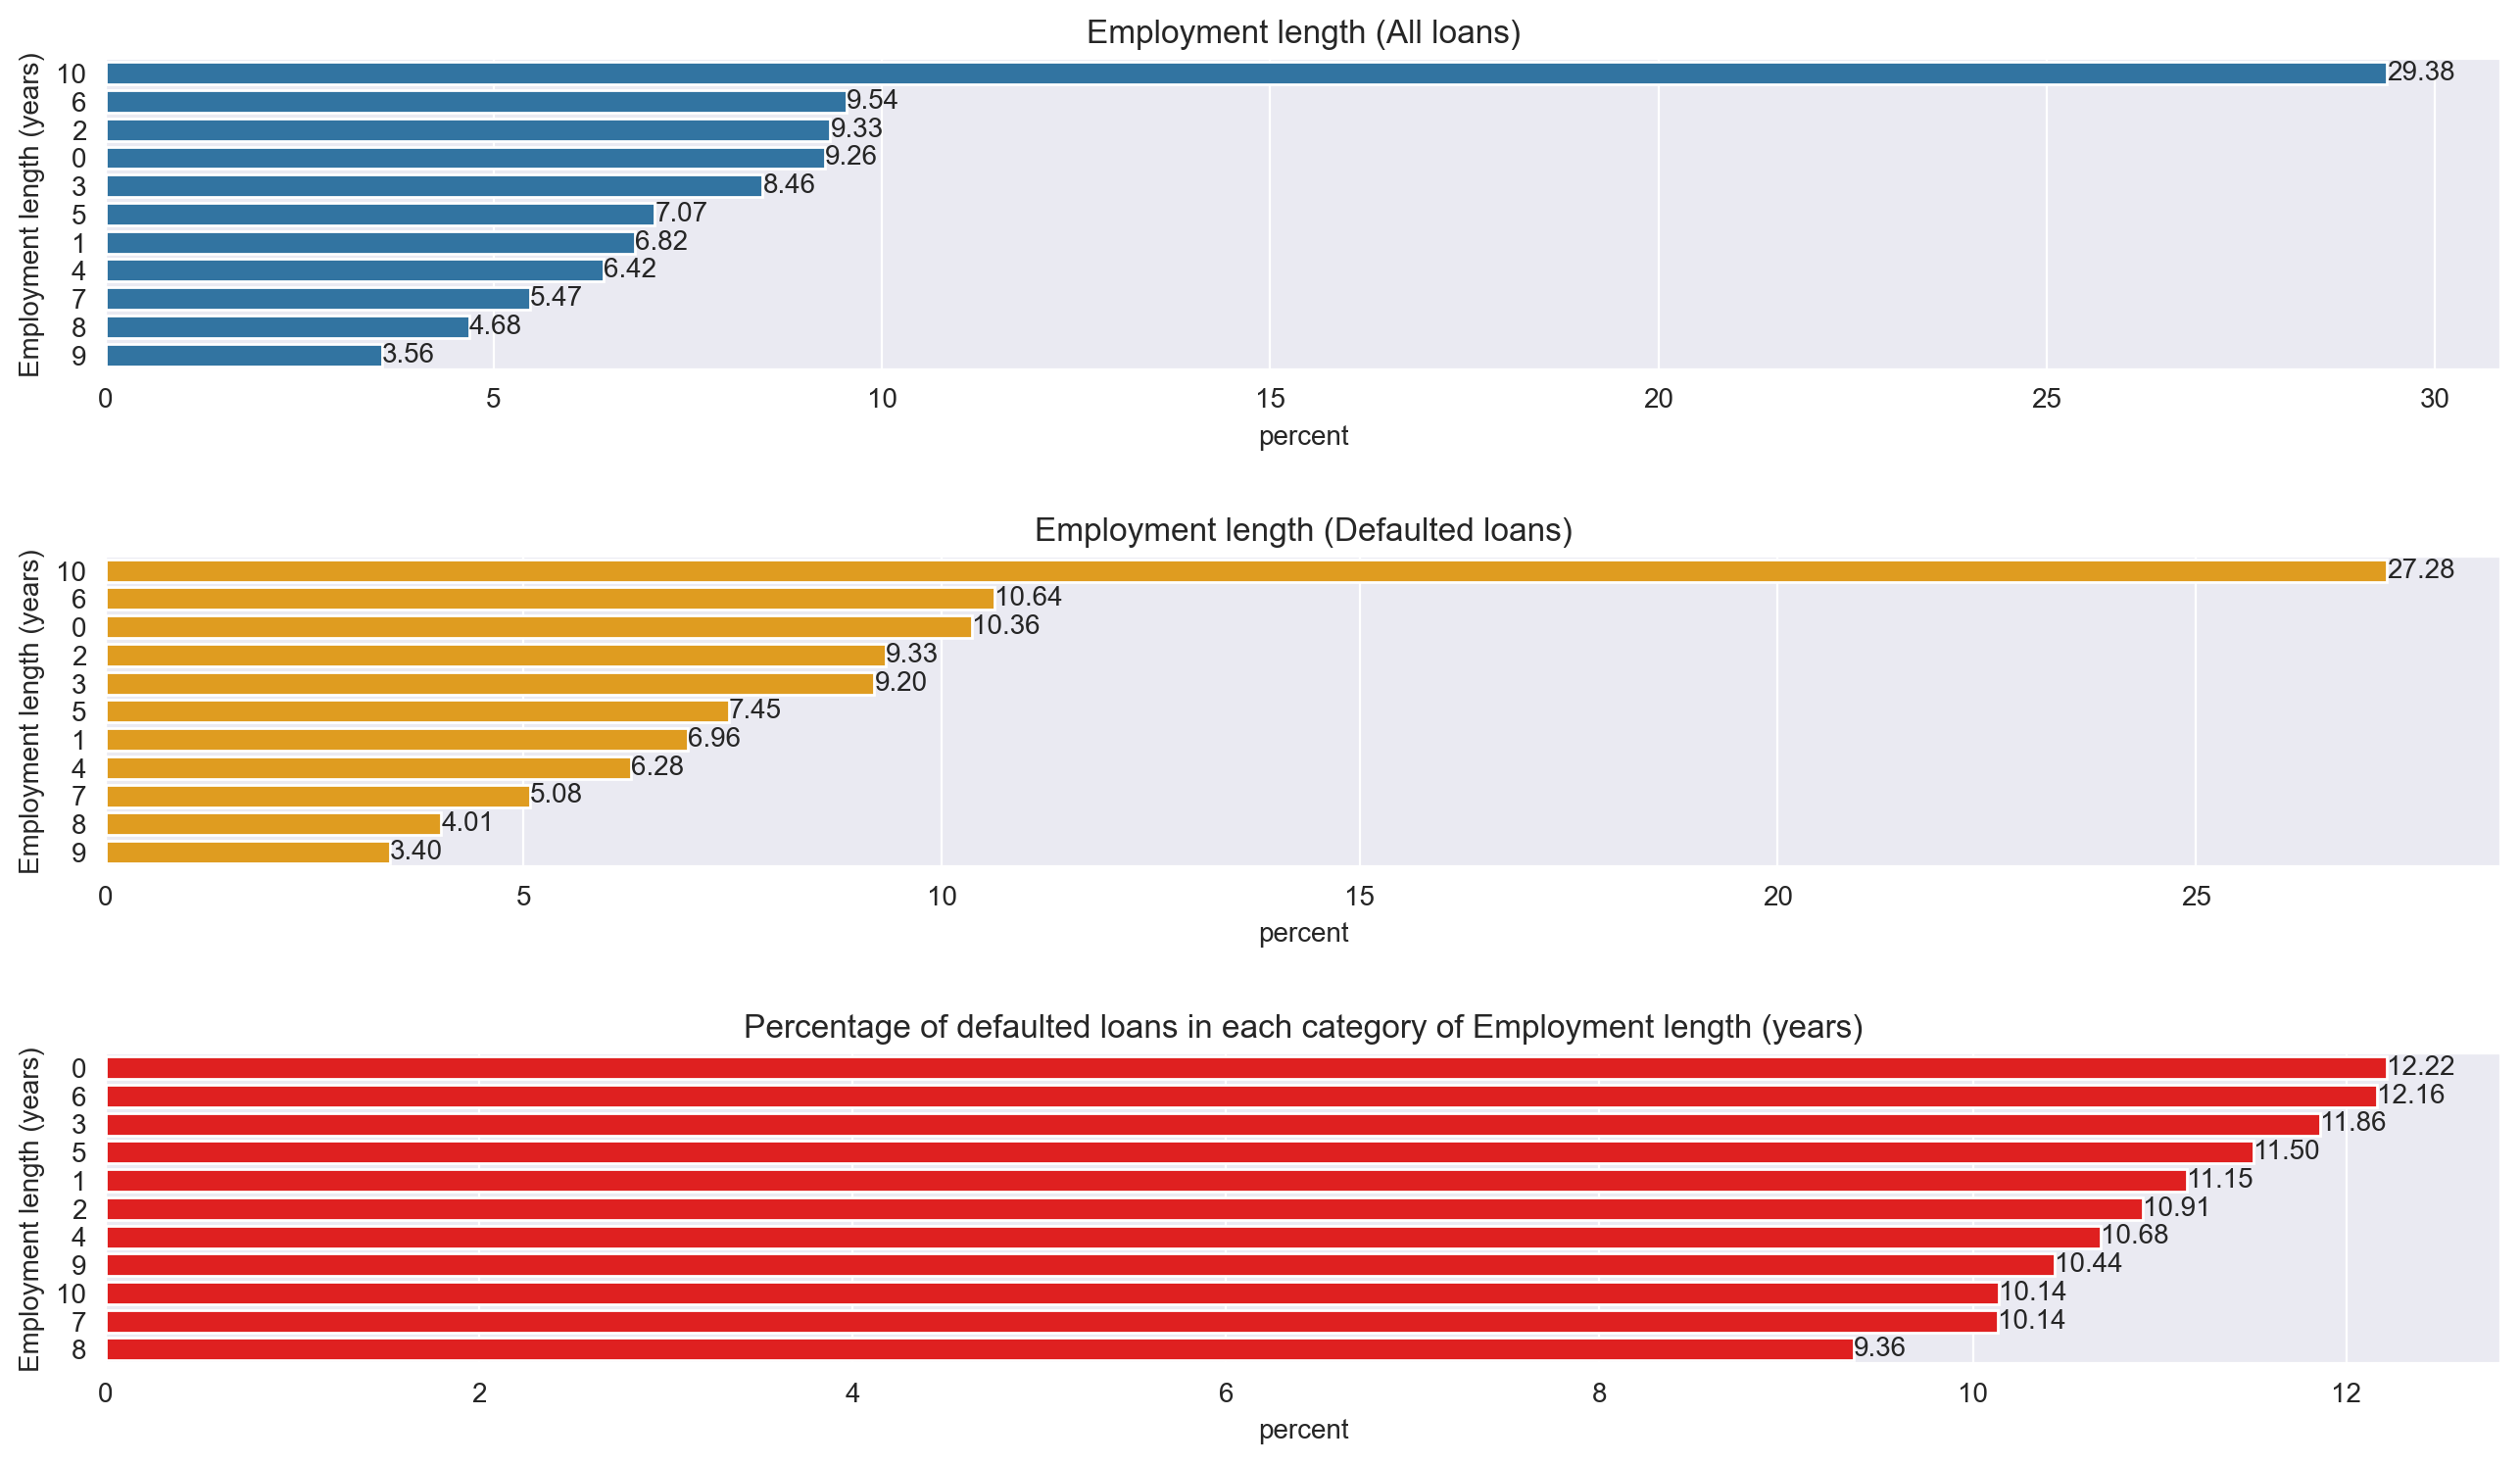

In [23]:
plot.plot_risk_comparison(df, defaulted_subset, 'employment_length', 'employment_length', title_1='Employment length (All loans)',
                          title_2='Employment length (Defaulted loans)', ylabel_1='Employment length (years)',
                          ylabel_2='Employment length (years)',fig_size=(14,9), padding=5)

The highest number of defaulted loans in the *employment length* category is in the 10+ years group, but this group also makes up the majority of this category. Turning to the third plot there doesn't seem to be a linear relationship between employment length and likelihood of defaulting on a loan. Therefore I do not believe that employment length is a good indicator of loss. 

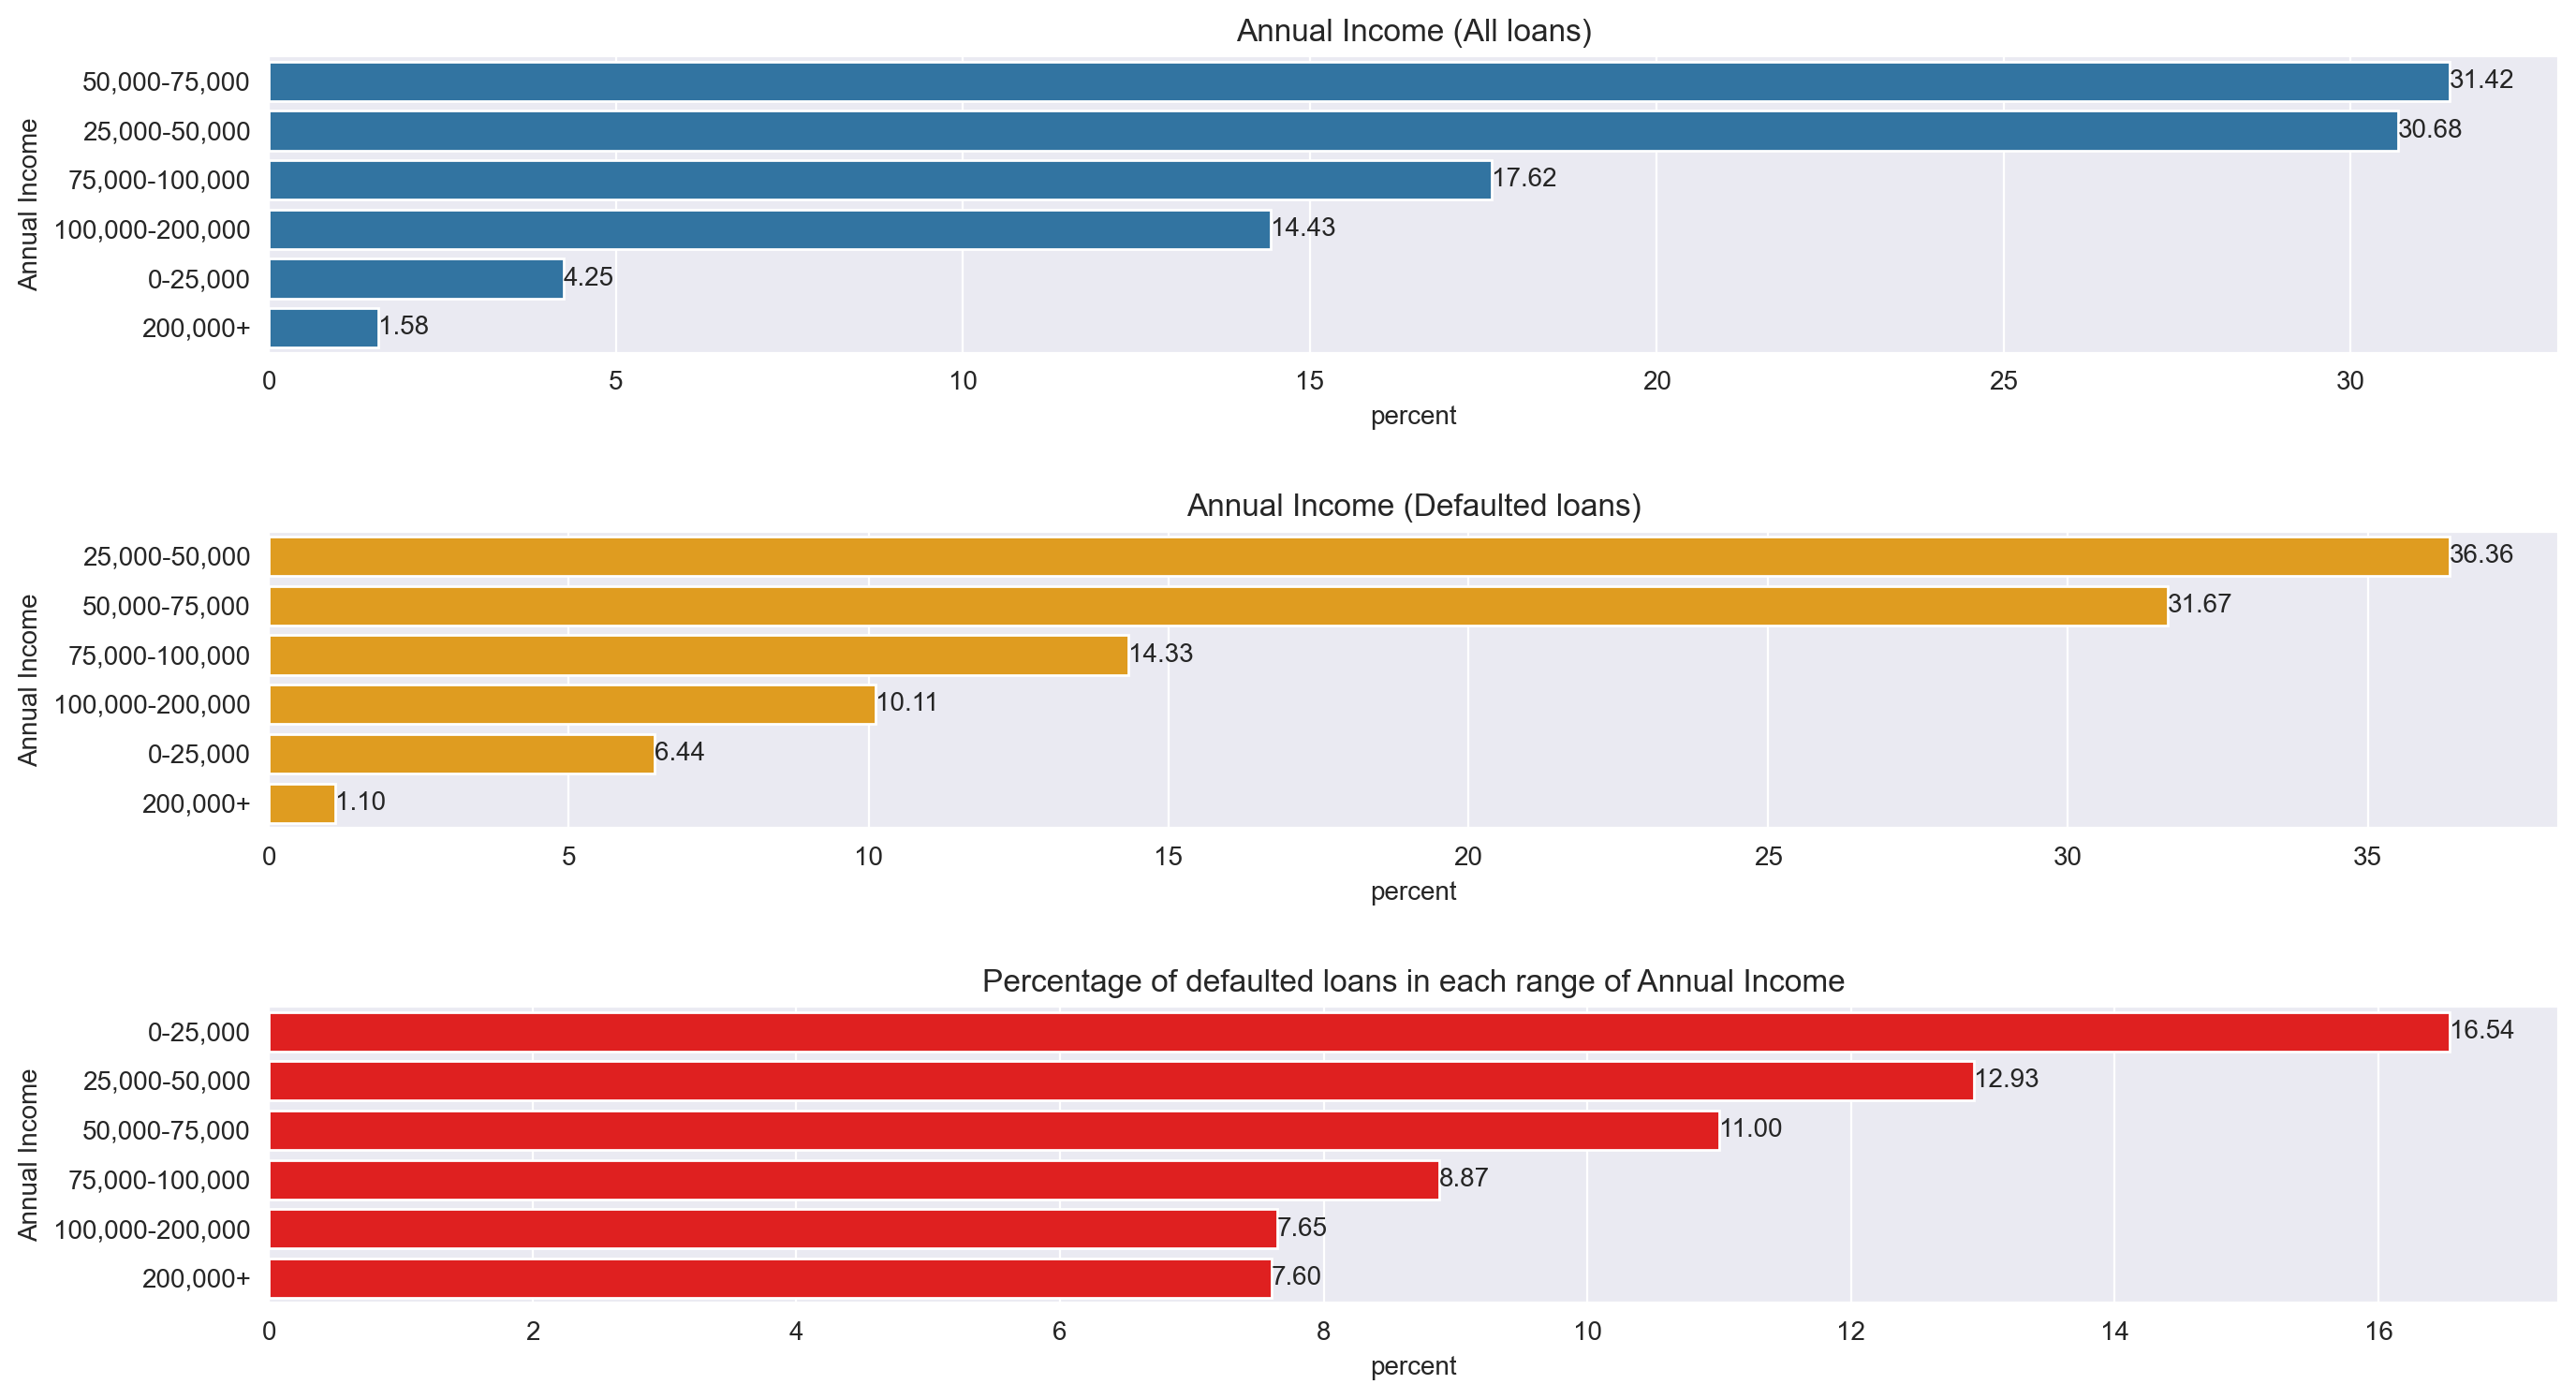

In [24]:
#Create ranges for annual_inc for analysis of continuous data
bins = [0, 25000, 50000, 75000, 100000, 200000, 1000000]
bin_label = ['0-25,000', '25,000-50,000', '50,000-75,000', '75,000-100,000', '100,000-200,000', '200,000+']
defaulted_subset['annual_inc_range'] = pd.cut(defaulted_subset['annual_inc'], bins, labels=bin_label)
df['annual_inc_range'] = pd.cut(df['annual_inc'], bins, labels=bin_label)

#Plot the data
plot.plot_risk_comparison(df, defaulted_subset, 'annual_inc_range', 'annual_inc_range', title_1='Annual Income (All loans)',
                          title_2='Annual Income (Defaulted loans)', title_3_cat='range', ylabel_1='Annual Income',
                          ylabel_2='Annual Income',fig_size=(14,9), padding=5)

The majority of loans here are taken out by customers who have an annual income in the range of 50 to 75 thousand, closely followed by customers with an annual income 25 to 50 thousand. Looking at the second plot we see things have changed, with customers in the 25 to 50 thousand group being dominant. The third plot suggests a linear relation between risk of defaulting and annual income, with the lowest paid being at higher risk of defaulting

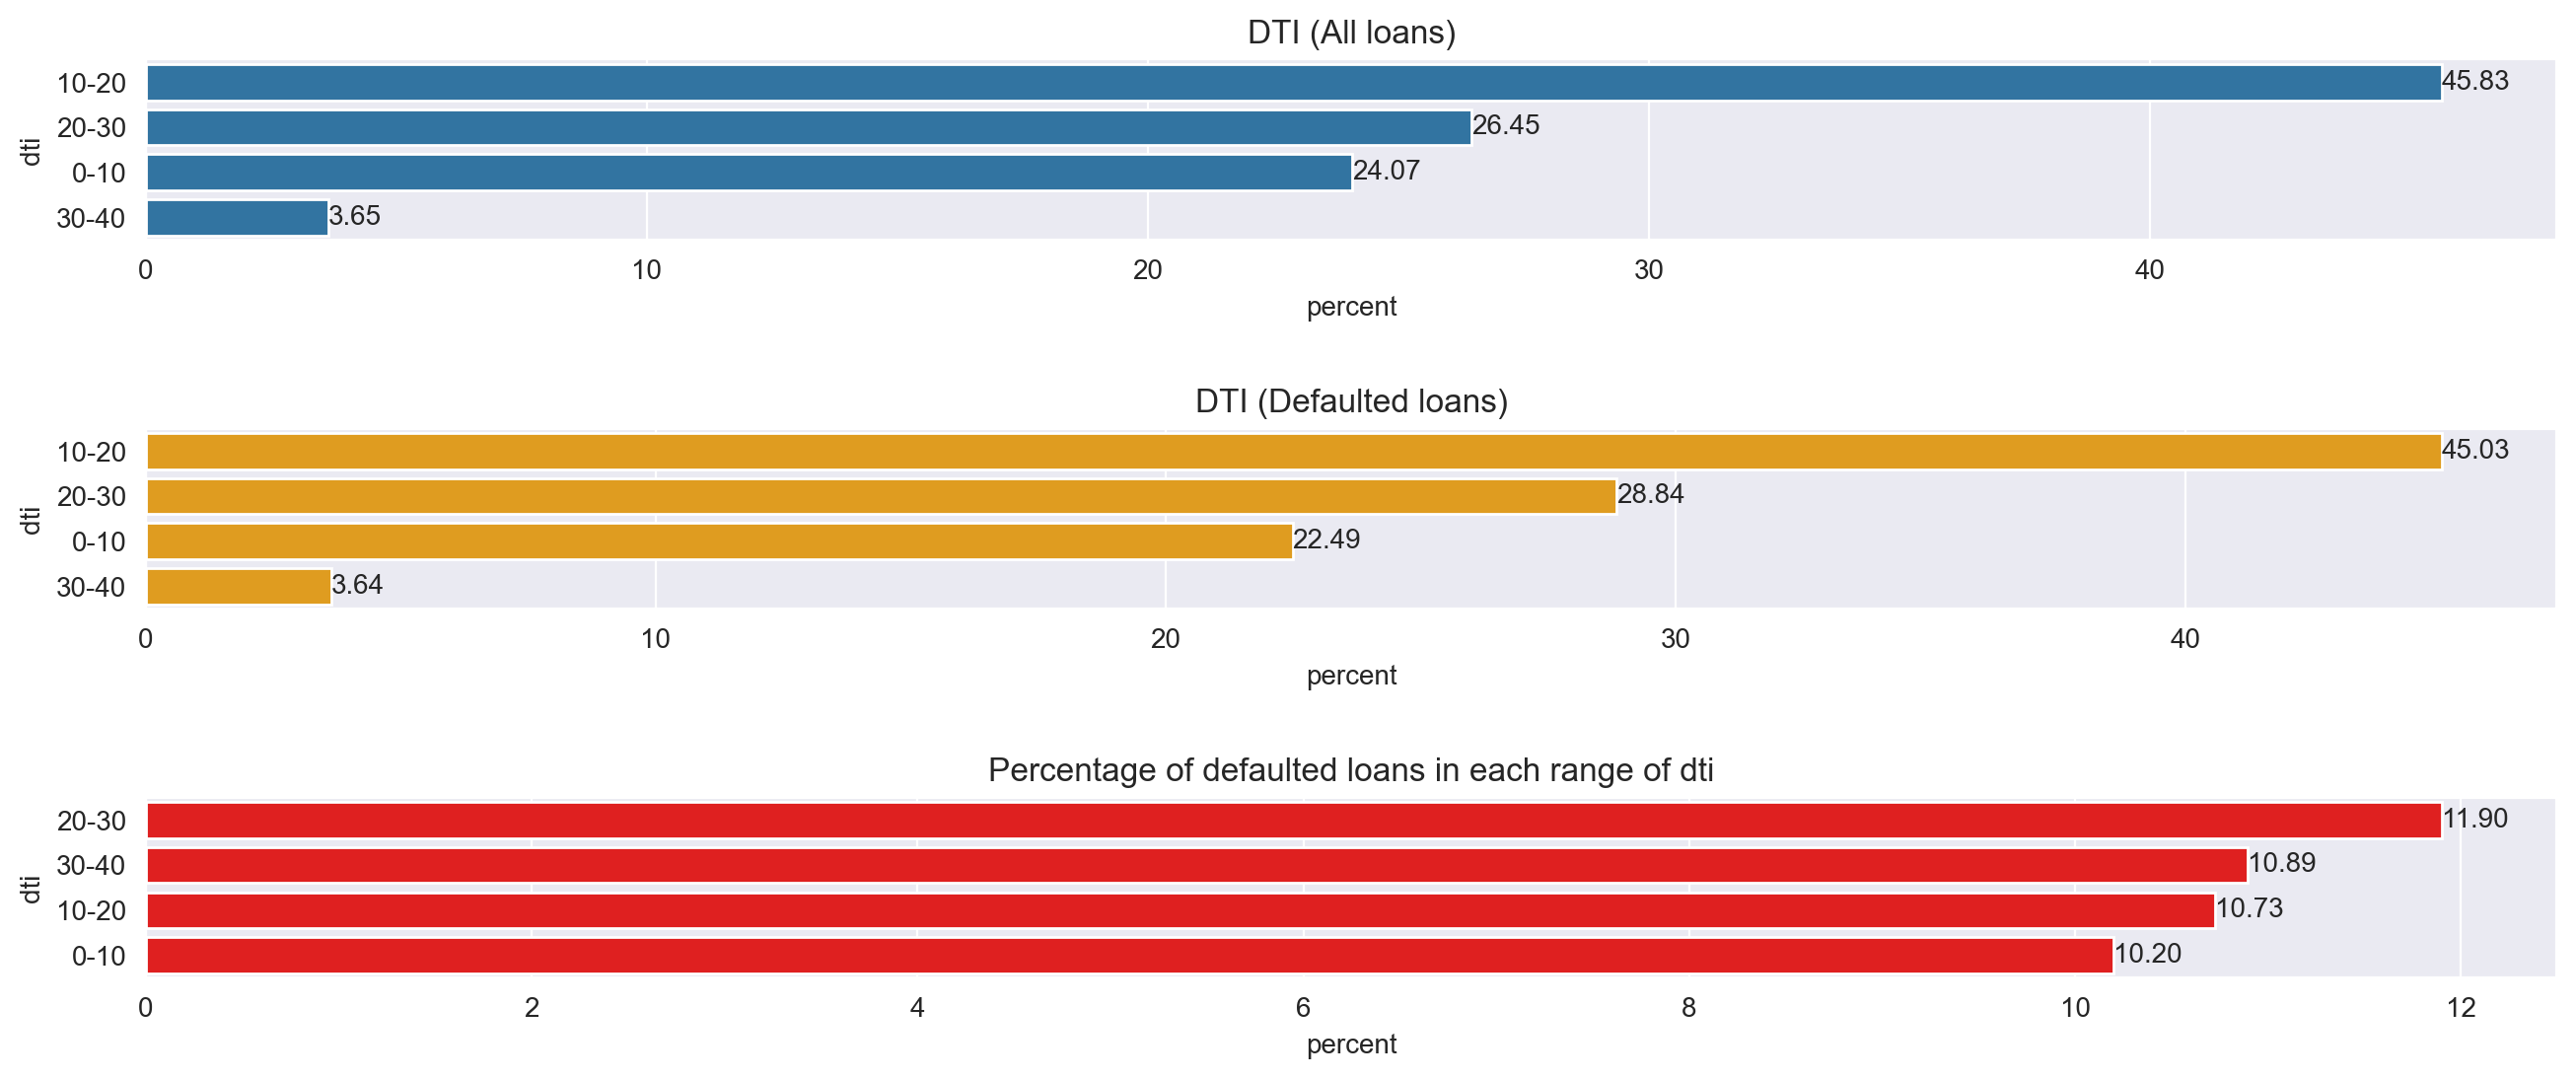

In [25]:
dti_bins = [-0.001, 10.0, 20.0, 30.0, 40.0]
dti_labels = ['0-10', '10-20', '20-30', '30-40']
defaulted_subset['dti_range'] = pd.cut(defaulted_subset['dti'], dti_bins, labels=dti_labels)
df['dti_range'] = pd.cut(df['dti'], dti_bins, labels=dti_labels)


#defaulted_subset['dti'].describe()
plot.plot_risk_comparison(df, defaulted_subset, 'dti_range', 'dti_range', title_1='DTI (All loans)',
                          title_2='DTI (Defaulted loans)', title_3_cat='range', ylabel_1='dti',
                          ylabel_2='dti',fig_size=(14,7), padding=5)

Finally, looking at dti we see the same type of linear relationship as with the *annual income* category, but there doesn't seem to be much separating them, suggesting that maybe dti is not a strong indicator of risk.

The above analysis suggest that the strongest indicator of a customer defaulting is the grade of the loan. Customers with higher incomes are less likely to default. Loans taken out for the purpose of small buisiness are of increaed risk of defaulting. Longer term loans are of slightly incresaed risk of defaulting.

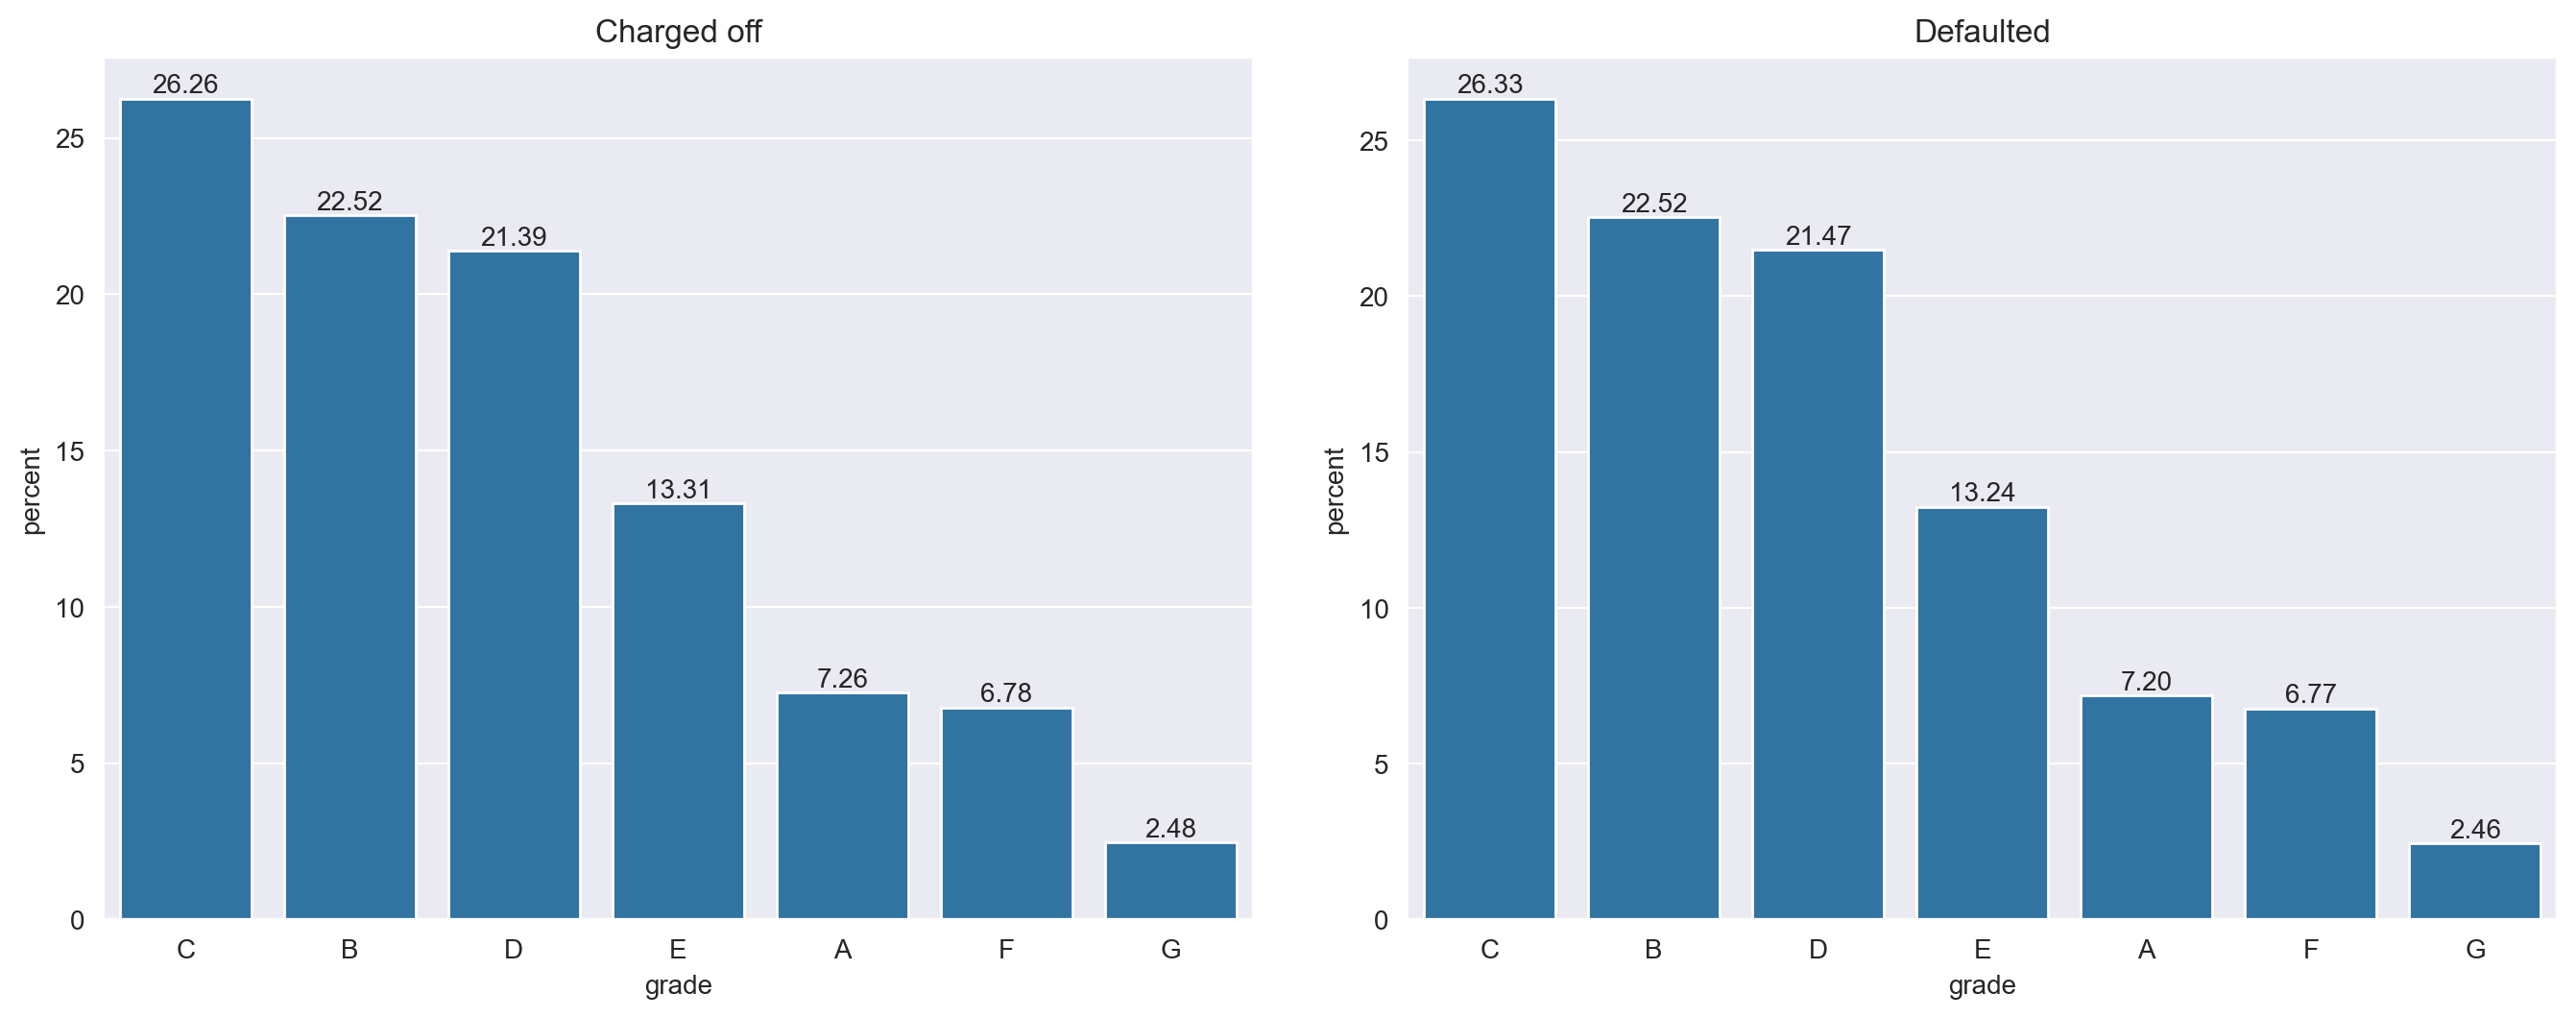

In [30]:
# Add annual income range to charged off
charged_off['annual_inc_range'] = pd.cut(defaulted_subset['annual_inc'], bins, labels=bin_label)
c=charged_off['annual_inc_range'].value_counts()

plot.plot_charged_default_comparison(charged_off, defaulted_subset, 'grade', title_1='Charged off', title_2= 'Defaulted',
                                     label_1='grade', label_2='percent', fig_size=(14,6))



The plots above compare the distribution of grades between charged off loans and defaulted loans. We note that they are virtually identical.

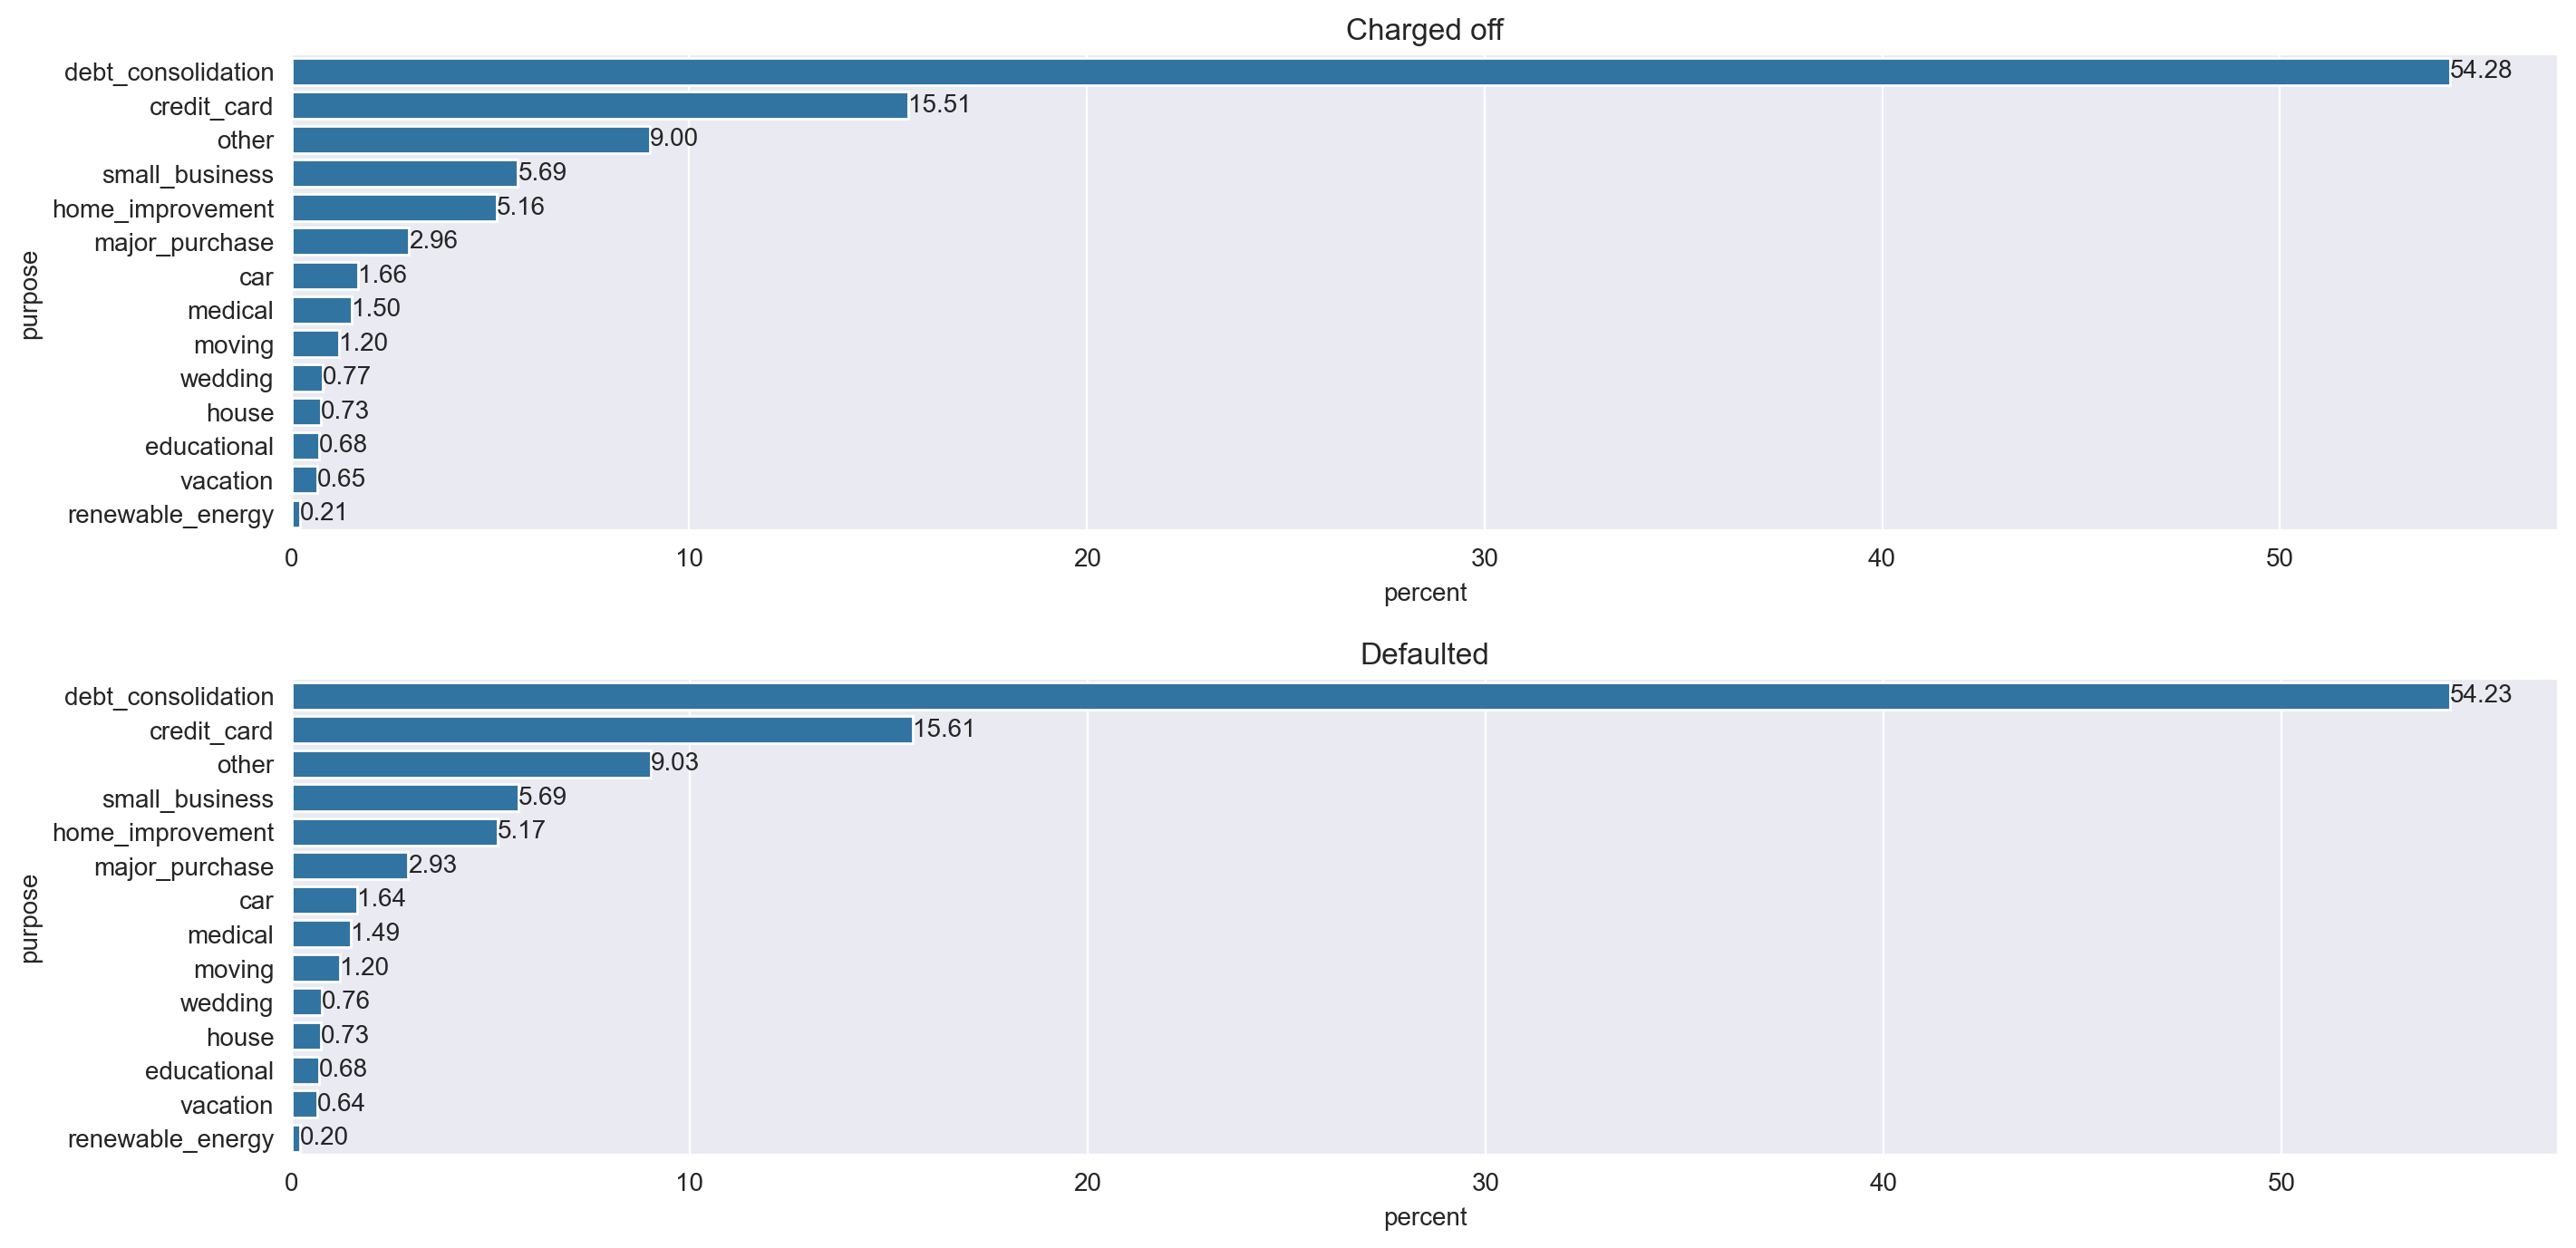

In [31]:
plot.plot_charged_default_comparison(charged_off, defaulted_subset, 'purpose', orientation='h', title_1='Charged off', title_2= 'Defaulted',
                                     label_1='percent', label_2='purpose', fig_size=(14,8), padding=4.0)



The plots above compare the distribution of values in the purpose category between charged off loans and defaulted loans. Again we see they are very close to each other.

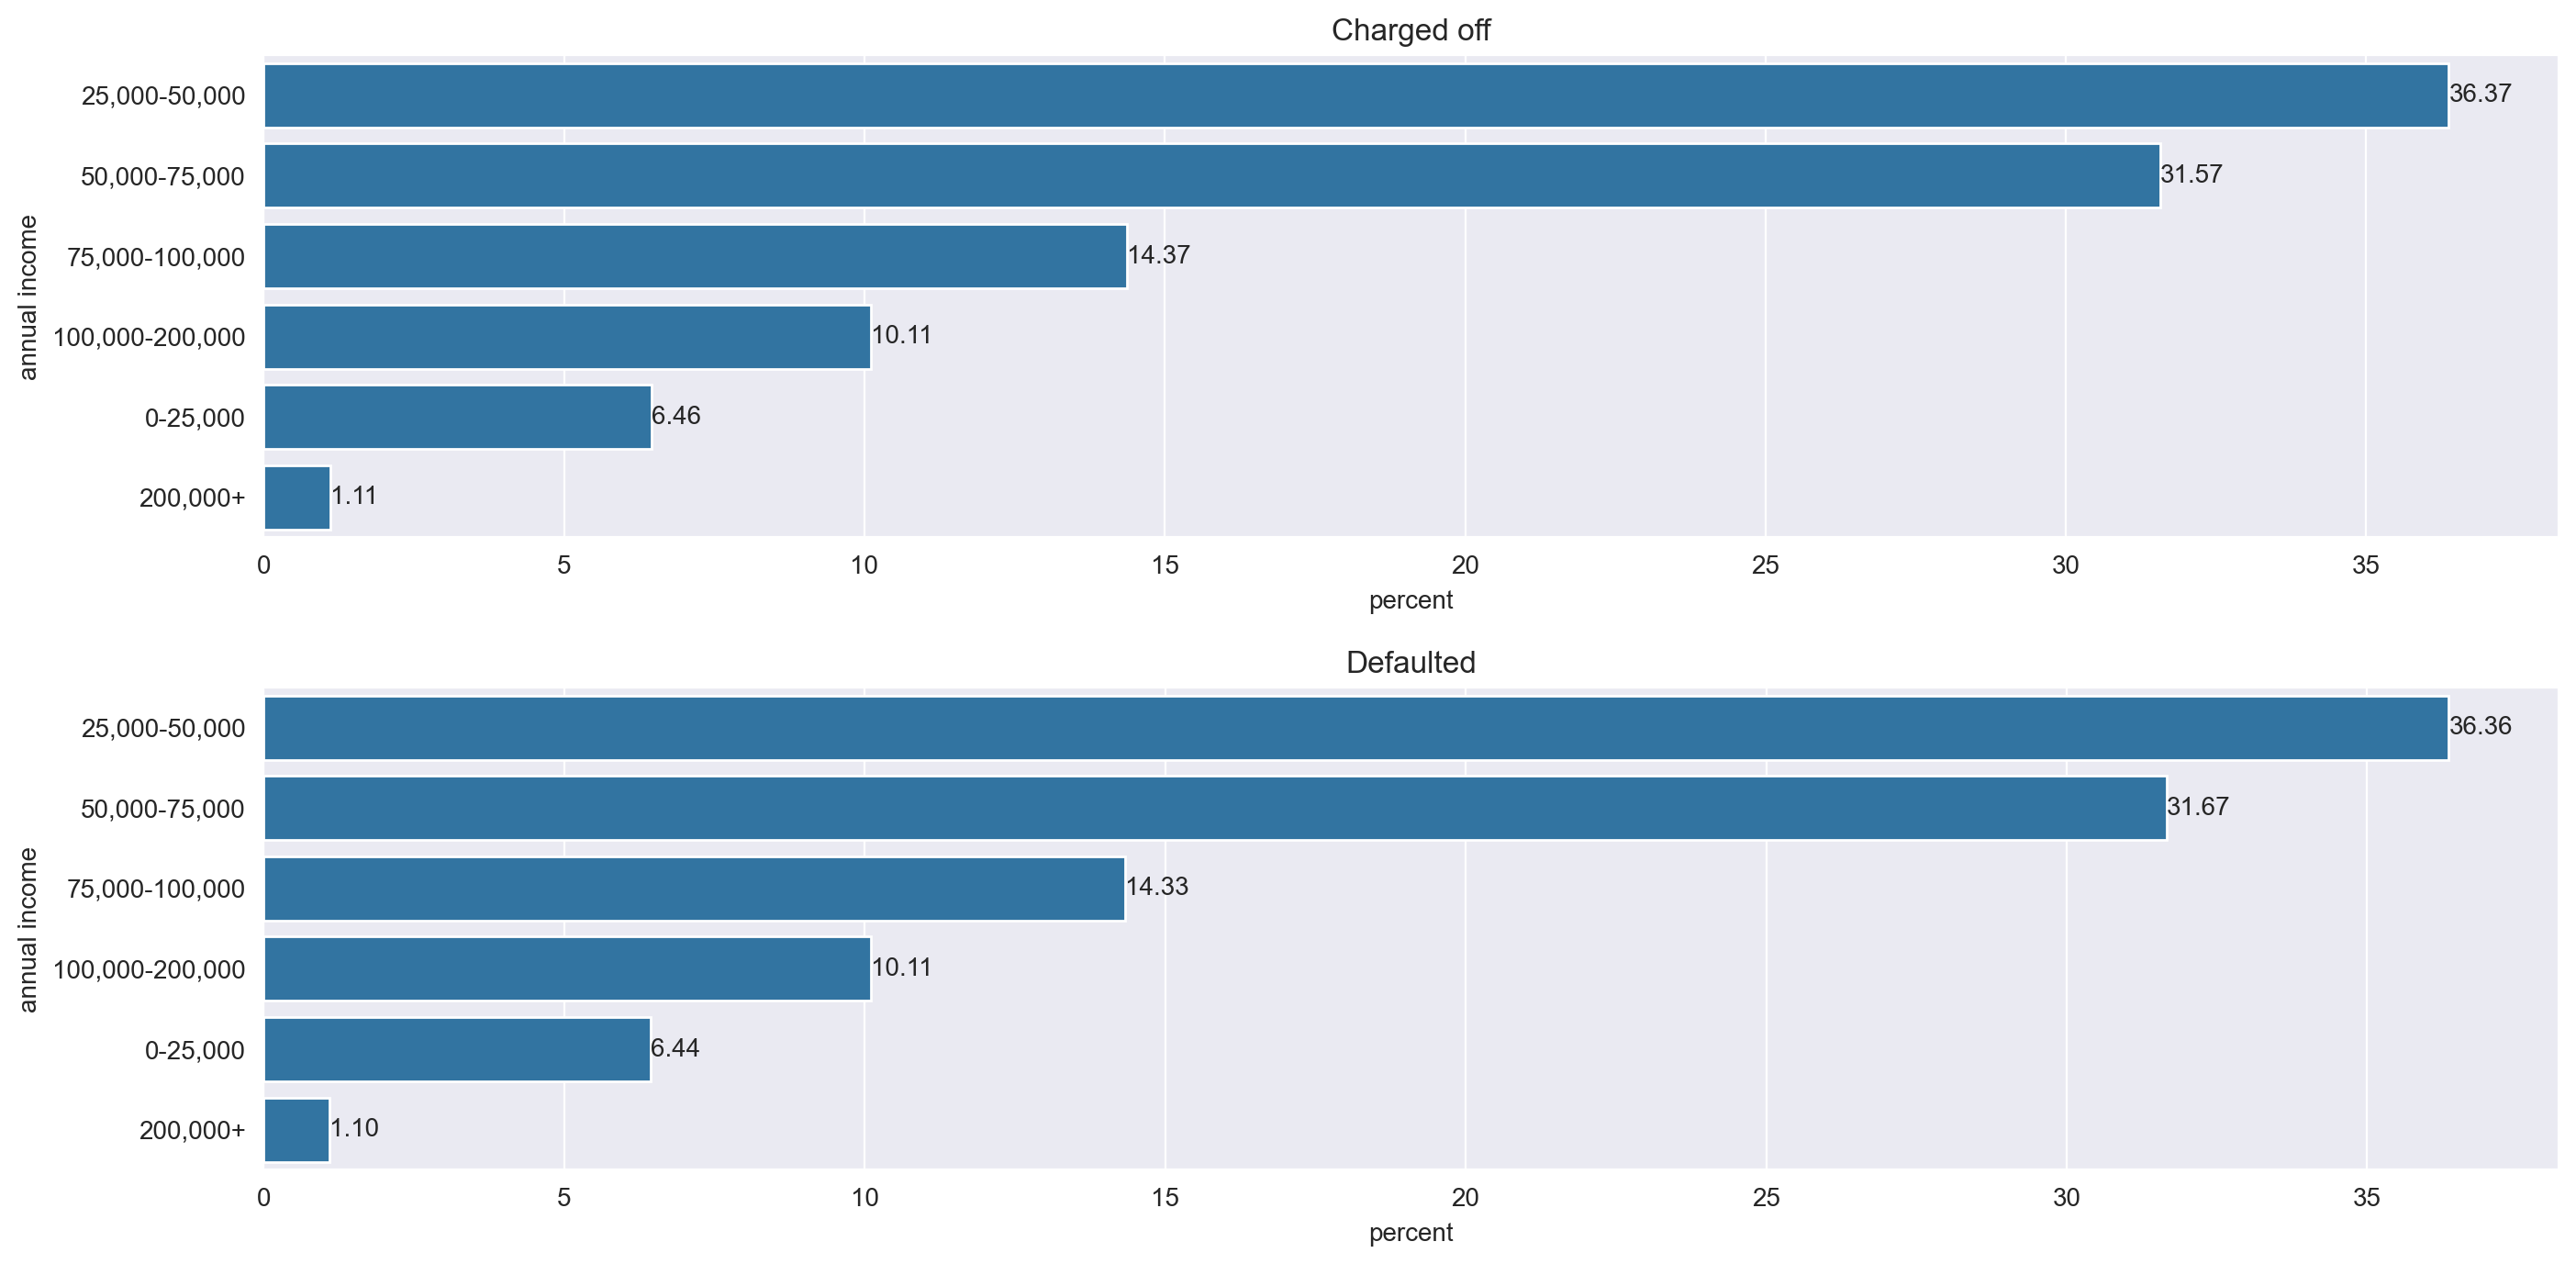

In [32]:
plot.plot_charged_default_comparison(charged_off, defaulted_subset, 'annual_inc_range', orientation='h', title_1='Charged off', title_2= 'Defaulted',
                                     label_1='percent', label_2='annual income', fig_size=(14,8), padding=4.0)

The plots above compare the distribution of income ranges for customer's annual income between charged off loans and defaulted loans. Yet again we see they are very similar.

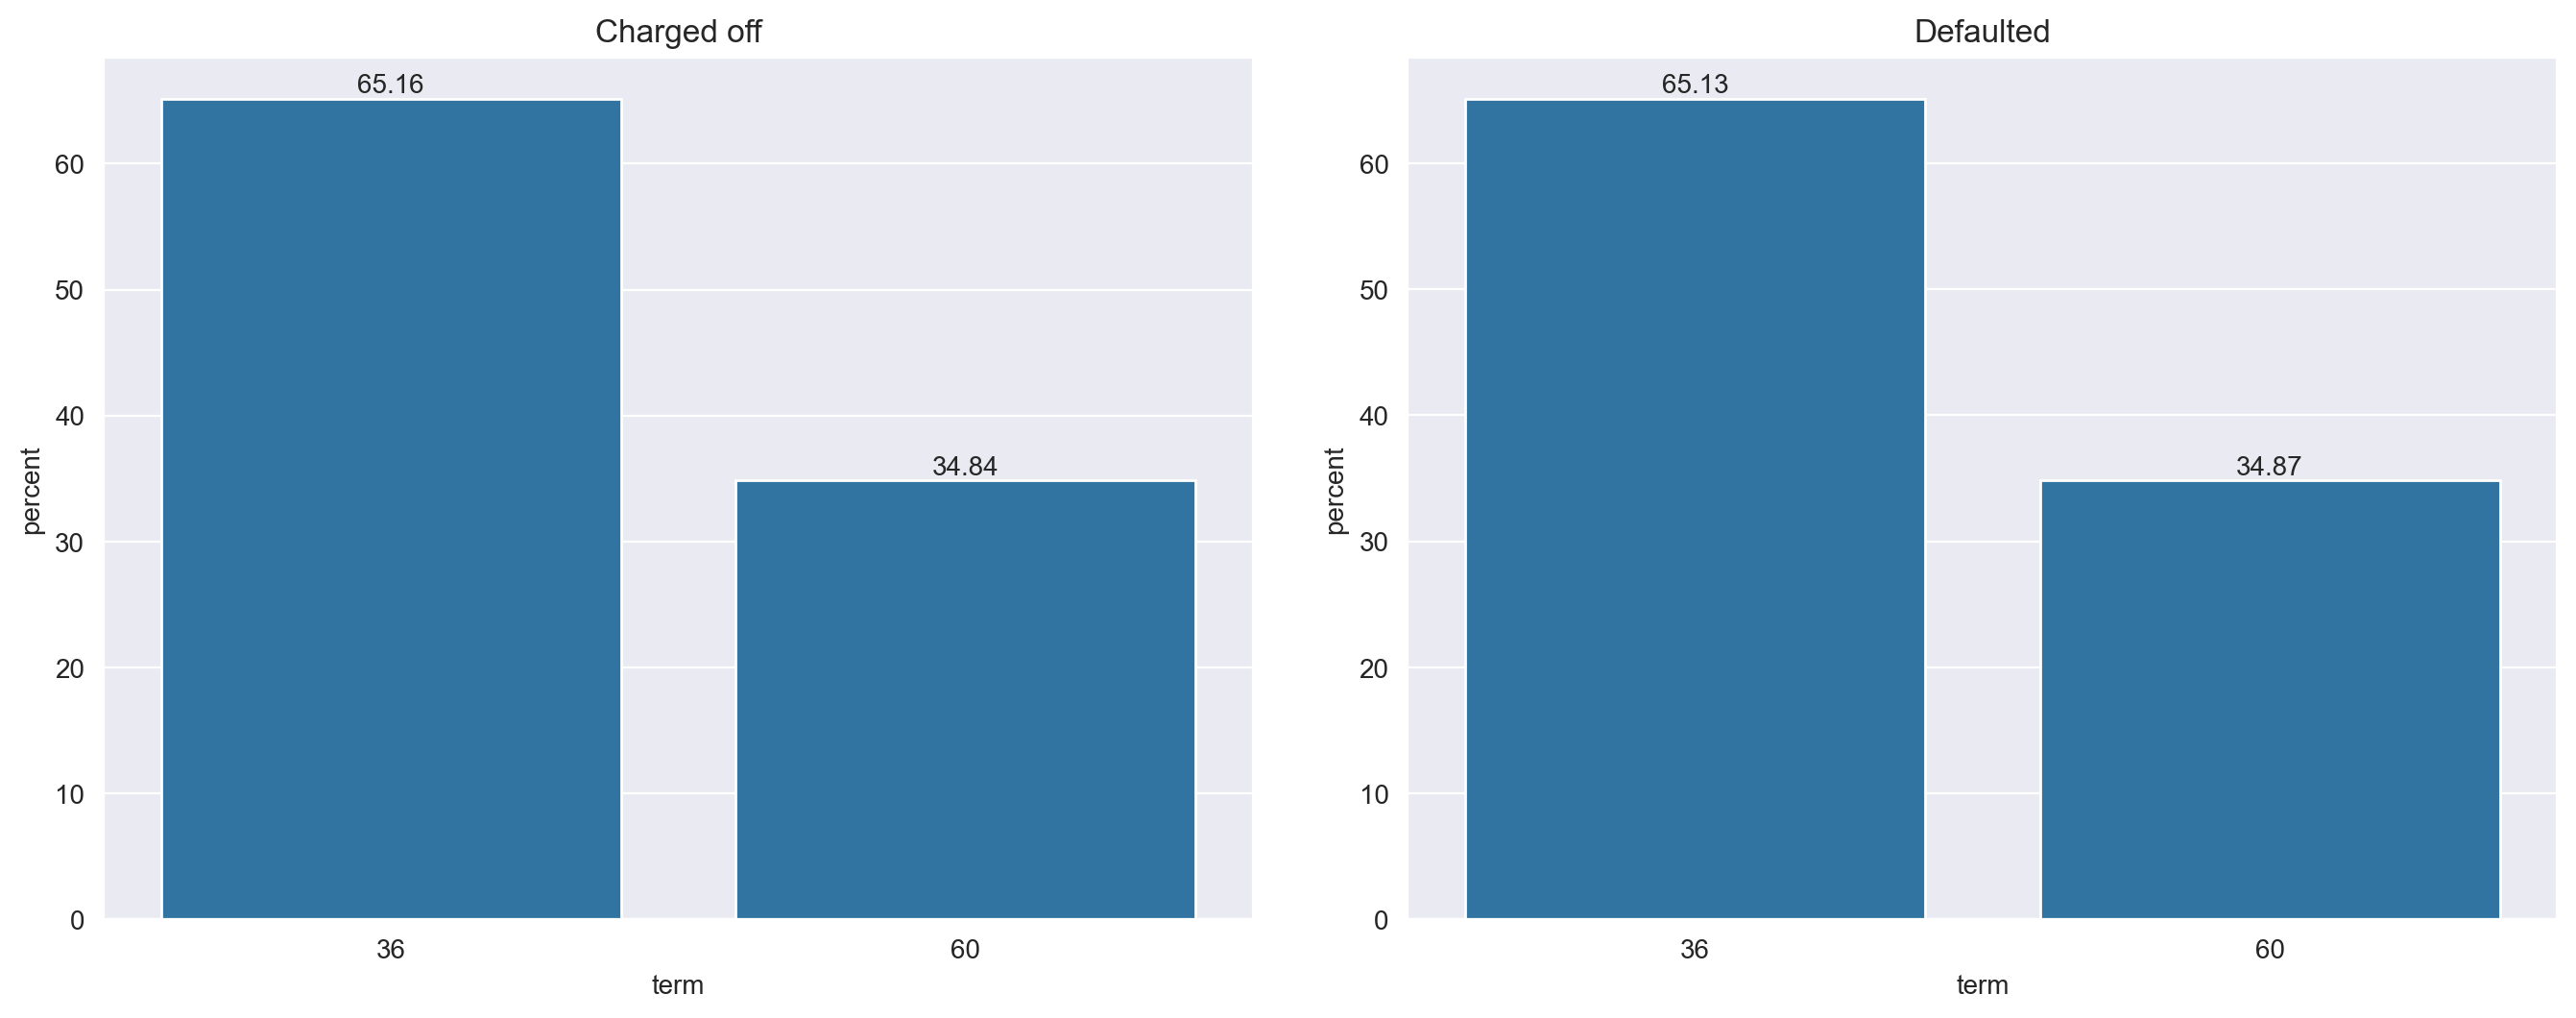

In [35]:
plot.plot_charged_default_comparison(charged_off, defaulted_subset, 'term', title_1='Charged off', title_2= 'Defaulted',
                                     label_1='term', label_2='percent', fig_size=(14,6))

Comparing the length of terms of charged off and defaulted loans also reveals virtually identical distributions.